# Telco Customer Churn Prediction
### Project Contributor: Sanjit Varma

# Importing Necessary Packages

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np 
import scipy.stats as stats
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier

# Importing the Data

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Initial Understanding of the Data (Checks for Datatypes and Missing Values)

Now that the data has been loaded. Let's 

In [3]:
def initial_info(data):
    print("")
    print("---------------------------------------------------")
    print("")
    print("First five rows of Dataframe:")
    display(data.head())
    print("---------------------------------------------------")
    print("")
    print("Statistical information of Dataframe:")
    display(data.describe())
    print("---------------------------------------------------")
    print("")
    print("Identifying Datatypes and checking for null values:")
    print("")
    display(data.info())   

In [4]:
initial_info(df)


---------------------------------------------------

First five rows of Dataframe:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---------------------------------------------------

Statistical information of Dataframe:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


---------------------------------------------------

Identifying Datatypes and checking for null values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-nul

None

## Checking for Duplicates

We can see above that there are no nulls in the dataset. Let us check if there are any duplicate customer entries by checking the customerID column.

In [5]:
df['customerID'].nunique()

7043

There are 7043 unique values. Therefore we can be confident that there are no duplicates.

## Making sure all columns are the correct Datatype

Why is the **SeniorCitizen** column in *int64* format?

In [6]:
df['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: int64

In [7]:
df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Seems like this column has been binarized into two categories: 1 or 0, with 1 indicating that the customer is a senior citizen.

Moving on, we can see that the **MonthlyCharges** column has *float64* datatype but the **TotalCharges** column is of *object* type. We need to find out why this is the case.

In [8]:
df['TotalCharges']

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

Since the values in this column were stored as string variables, there is a possibility that there are missing values not being recognized as nulls. These empty values could be stored as empty strings.

In [9]:
empty_total_charge_count = df.loc[df['TotalCharges']==' ', 'TotalCharges'].count()
print(f'Number of Records with missing Total Charges: {empty_total_charge_count}')

Number of Records with missing Total Charges: 11


It's good that we checked as we now found that 11 different records seem to have missing values. Is there a reason for why these records have missing values in the **TotalCharges** column?

The answer may lie in the **tenure** column. The **tenure** column provides information about the number of months the customer has been subscribed to the company's services. Let us observe the number of months that these customers have been subscribed.

In [10]:
df.loc[df['TotalCharges']==' ',['tenure','TotalCharges']]

,tenure,TotalCharges
488,0,
753,0,
936,0,
1082,0,
1340,0,
3331,0,
3826,0,
4380,0,
5218,0,
6670,0,


All of them have their **tenure** value as 0. Perhaps they have not completed their first month yet? Maybe they are on their free trial and therefore have not been billed yet?

Let us look at the total number of records in the dataset that have their **tenure** value = 0.

In [11]:
zero_tenure_count = len(df[df['tenure']==0])
print(f'The number of records with Tenure value as 0 is : {zero_tenure_count}')

The number of records with Tenure value as 0 is : 11


As we can see from above, there are 11 records in the entire dataframe with the **tenure** value equalling 0. This means that only the customers with missing **TotalCharges** have 0 months of subscription. Therefore, we can conclude in confidence that the missing values in the **TotalCharges** column is not because of a mistake. It is because they are likely in their trial period and have not been billed yet.

To deal with these missing values, we will use the monthly charge of these customers as their total charge.

In [12]:
df.loc[df['TotalCharges']==' ',['MonthlyCharges','TotalCharges']]

,MonthlyCharges,TotalCharges
488,52.55,
753,20.25,
936,80.85,
1082,25.75,
1340,56.05,
3331,19.85,
3826,25.35,
4380,20.00,
5218,19.70,
6670,73.35,


In [13]:
# Replacing missing values with monthly charge values
df.loc[df['TotalCharges']==' ','TotalCharges'] = df.loc[df['TotalCharges']==' ','MonthlyCharges']

#Converting the TotalCharges column to float64 dtype

df['TotalCharges'] = df['TotalCharges'].astype('float64')

Let's check if this worked as expected.

In [14]:
df.loc[df['TotalCharges']==' ',]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


There are no customers now with missing **Total Charges**. This concludes our problem of handling missing values.

## Feature Engineering

Let us look at the columns in our dataset once again:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Let's observe what kind of groups are seen in our categorical columns. We want to drop the **customerID** column here as there would be 1 group for each user and would therefore lead to too many groups. Also the **customerID** column may not be useful for us later on when training our models.

In [16]:
df = df.drop('customerID', axis = 1)
df_columns = list(df.select_dtypes(include = 'object').columns)

category_dict = {}

for col in df_columns:
    category_dict[col] = list(set(df[col]))

In [17]:
category_dict

{'gender': ['Female', 'Male'],
 'Partner': ['No', 'Yes'],
 'Dependents': ['No', 'Yes'],
 'PhoneService': ['No', 'Yes'],
 'MultipleLines': ['No phone service', 'Yes', 'No'],
 'InternetService': ['No', 'Fiber optic', 'DSL'],
 'OnlineSecurity': ['No', 'Yes', 'No internet service'],
 'OnlineBackup': ['No', 'Yes', 'No internet service'],
 'DeviceProtection': ['No', 'Yes', 'No internet service'],
 'TechSupport': ['No', 'Yes', 'No internet service'],
 'StreamingTV': ['No', 'Yes', 'No internet service'],
 'StreamingMovies': ['No', 'Yes', 'No internet service'],
 'Contract': ['Month-to-month', 'One year', 'Two year'],
 'PaperlessBilling': ['No', 'Yes'],
 'PaymentMethod': ['Bank transfer (automatic)',
  'Electronic check',
  'Credit card (automatic)',
  'Mailed check'],
 'Churn': ['No', 'Yes']}

Perhaps we could reduce the number of groups to two for each category and binarize all the values into numerical format.

Let's binarize the **gender** column into 0 and 1. With 1 equalling *Male* and 0 equalling *Female*.

In [18]:
df['gender'] = df['gender'].apply(lambda x: 0 if x=='Female' else 1)

There are several columns with ***Yes*** or ***No*** with a third category involved as well. Let's first try and integrate the third category into one of the *Yes*/*No* categories and then binarize those columns as well.

The **MultipleLines** column has 3 categories, ***No phone service***, ***No*** and ***Yes***. Users that do not have phone service also do not have multiple lines. Therefore, we can combine the two groups (i.e. ***No*** and ***No phone service***) into one category.

In [19]:
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: 'No' if x == 'No phone service' else x)

We can reduce the number of categories in the **InternetService** column as well by grouping  *DSL* and *Fiber Optic* to see if a customer has internet service or not. So we will combine the groups ***Fiber optic*** and ***DSL*** into one group.

In [20]:
df['InternetService'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1).astype('int64')

We can see above that despite there being an **InternetService** column, the columns- **OnlineSecurity**, **OnlineBackup**, **DeviceProtection**, **TechSupport**, **StreamingTV** and **StreamingMovies** all have a "*No Internet Service*" category. Perhaps we could reduce the number of categories in these columns by including all the customers with no internet service within the *No* category. This is because a customer who does not have internet service also does not have any of these aforementioned services.

In [21]:
no_net_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
              'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in no_net_cols:
    df[col] = df[col].apply(lambda x: 'No' if x == 'No internet service' else x)

Now, looking at the **Contract** column, perhaps we can reduce the number of groups in a new column called **loyalty** where customers are divided into two groups- *0* for *month-to-month* customers and *1* for customers with contracts of 1 year or more.

In [22]:
df['loyalty'] =  df['Contract'].apply(lambda x: 0 if x == 'Month-to-month' else 1).astype('int64')
df = df.drop('Contract',axis = 1)

Let's now look at the groups in our categorical columns after engineering.

In [23]:
df_columns = list(df.select_dtypes(include = 'object').columns)

category_dict = {}

for col in df_columns:
    category_dict[col] = list(set(df[col]))
    
category_dict

{'Partner': ['No', 'Yes'],
 'Dependents': ['No', 'Yes'],
 'PhoneService': ['No', 'Yes'],
 'MultipleLines': ['No', 'Yes'],
 'OnlineSecurity': ['No', 'Yes'],
 'OnlineBackup': ['No', 'Yes'],
 'DeviceProtection': ['No', 'Yes'],
 'TechSupport': ['No', 'Yes'],
 'StreamingTV': ['No', 'Yes'],
 'StreamingMovies': ['No', 'Yes'],
 'PaperlessBilling': ['No', 'Yes'],
 'PaymentMethod': ['Bank transfer (automatic)',
  'Electronic check',
  'Credit card (automatic)',
  'Mailed check'],
 'Churn': ['No', 'Yes']}

With the exception of **Payment Method** , we now have only two groups of either ***Yes*** or ***No*** in each categorical column.

Let's now convert these groups to binary numbers for later use when training our models.

In [24]:
#Yes/No Columns only
y_n_cols = list(df.select_dtypes(include = 'object').columns)
y_n_cols.remove('PaymentMethod')

In [25]:
for col in y_n_cols:
    
    df[col] = df[col].apply(lambda x: 0 if x == 'No' else 1).astype('int64')

Now we can take a look at what our groups look like:

In [26]:
df_columns = list(df.drop(['tenure','MonthlyCharges','TotalCharges'],axis=1).columns)

category_dict = {}

for col in df_columns:
    category_dict[col] = list(set(df[col]))
    
category_dict

{'gender': [0, 1],
 'SeniorCitizen': [0, 1],
 'Partner': [0, 1],
 'Dependents': [0, 1],
 'PhoneService': [0, 1],
 'MultipleLines': [0, 1],
 'InternetService': [0, 1],
 'OnlineSecurity': [0, 1],
 'OnlineBackup': [0, 1],
 'DeviceProtection': [0, 1],
 'TechSupport': [0, 1],
 'StreamingTV': [0, 1],
 'StreamingMovies': [0, 1],
 'PaperlessBilling': [0, 1],
 'PaymentMethod': ['Bank transfer (automatic)',
  'Electronic check',
  'Credit card (automatic)',
  'Mailed check'],
 'Churn': [0, 1],
 'loyalty': [0, 1]}

We have binarized all groups except **PaymentMethod** into *0*'s and *1*'s.

In [27]:
# First 10 rows of the DataFrame
df[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,loyalty
0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,Electronic check,29.85,29.85,0,0
1,1,0,0,0,34,1,0,1,1,0,1,0,0,0,0,Mailed check,56.95,1889.50,0,1
2,1,0,0,0,2,1,0,1,1,1,0,0,0,0,1,Mailed check,53.85,108.15,1,0
3,1,0,0,0,45,0,0,1,1,0,1,1,0,0,0,Bank transfer (automatic),42.30,1840.75,0,1
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,1,Electronic check,70.70,151.65,1,0
5,0,0,0,0,8,1,1,1,0,0,1,0,1,1,1,Electronic check,99.65,820.50,1,0
6,1,0,0,1,22,1,1,1,0,1,0,0,1,0,1,Credit card (automatic),89.10,1949.40,0,0
7,0,0,0,0,10,0,0,1,1,0,0,0,0,0,0,Mailed check,29.75,301.90,0,0
8,0,0,1,0,28,1,1,1,0,0,1,1,1,1,1,Electronic check,104.80,3046.05,1,0
9,1,0,0,1,62,1,0,1,1,1,0,0,0,0,0,Bank transfer (automatic),56.15,3487.95,0,1


# Exploratory Data Analysis

Let us take a look at all our columns again.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  PaperlessBilling  7043 non-null   int64  
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


## Identifying features of Churned Customers

We can now conduct an exploration into which of the features above are causing the customer to churn.

In [29]:
#Dataframe consisting of only churned customers
churn_df = df[df['Churn']== 1]

#Dataframe consisting of customers who have not churned
non_churn_df = df[df['Churn']== 0]

### Monthly Charges

Using intuition, one may assume that the cost of the service may have a significant impact on a customer's decision on whether or not to continue their subscription. Let's look at a histogram of churned customers' **monthly** and **total** charges to see if we can find any insights to confirm this theory.

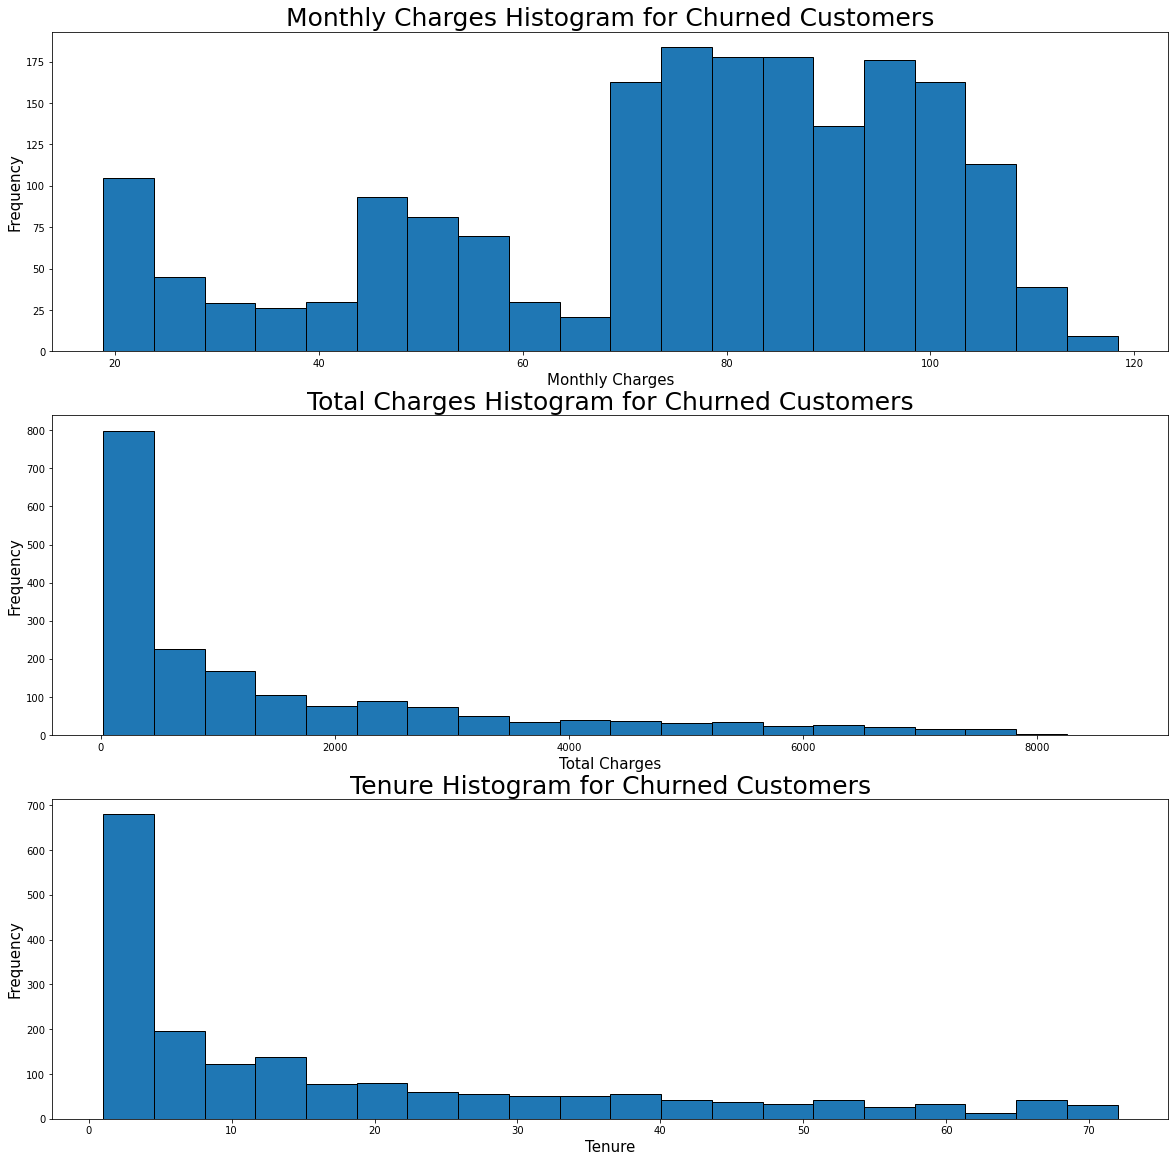

In [30]:
fig,ax = plt.subplots(3,figsize=(20,20))

ax[0].hist(churn_df['MonthlyCharges'],bins=20, edgecolor='black')
ax[1].hist(churn_df['TotalCharges'],bins=20, edgecolor='black')
ax[2].hist(churn_df['tenure'],bins=20, edgecolor='black')

ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].set_xlabel('Monthly Charges',fontsize=15)
ax[0].set_title('Monthly Charges Histogram for Churned Customers', fontsize=25)
ax[1].set_ylabel('Frequency', fontsize=15)
ax[1].set_xlabel('Total Charges', fontsize=15)
ax[1].set_title('Total Charges Histogram for Churned Customers', fontsize=25)
ax[2].set_ylabel('Frequency', fontsize=15)
ax[2].set_xlabel('Tenure', fontsize=15)
ax[2].set_title('Tenure Histogram for Churned Customers', fontsize=25);

We can see from the first histogram displaying **Monthly Charges** that customers paying higher monthly charges are churning more.

The **Total Charges** histogram is strongly skewed to the right. Seems like a lot of customers are churning within the initial period of their subscription.

A lot of customers are churning within the first two months of subscription **tenure**. This is likely because people are leaving after their month-long trial period ends.

To confirm the theory that **Monthly charges** are a key factor in causing customer churn, we need to identify if there is a statistically significant difference between the monthly charges of churned customers and continuing customers.

Let us conduct a hypothesis test for this.

* **Alternative Hypothesis** : "There **is** a significant difference in monthly charges between churned and continuing customers.

* **Null Hypothesis** : "There **is NOT** a significant difference in monthly charges between churned and continuing customers.

In [31]:
churn_charges = list(churn_df['MonthlyCharges'])
non_churn_charges = list(non_churn_df['MonthlyCharges'])

In [32]:
alpha = 0.05

result = stats.ttest_ind(non_churn_charges, churn_charges, 
                      equal_var=False).pvalue

if result >= alpha:
    print('Fail to reject the null hypothesis')
else:
    print('Reject the null hypothesis')    

Reject the null hypothesis


Based on the result of the above test, we can reject the null hypothesis. Therefore, we can conclude with confidence that there is a significant difference in **Monthly Charges** between churned and continuing customers.

Having identified that the monthly fee for customers is a significant factor of customers leaving, let us look at some of the categorical features to see which other factors may cause customer churn.

In [33]:
def compare_churn(column):
    
    df_churn = pd.DataFrame(churn_df.groupby(column)['gender'].count())
    df_churn.columns = ['Customers Churned Count']
    df_total = pd.DataFrame(df.groupby(column)['gender'].count())
    df_total.columns = ['Total Customer Count']
    final_df = pd.merge(df_total,df_churn,on=column)
    final_df['% of Customers Churned'] = [f'{round((a/b)*100,2)}%' for a,b in zip(final_df['Customers Churned Count'],final_df['Total Customer Count'])]

    display(final_df)

    fig, ax = plt.subplots(figsize = (20,12))

    all_y_values = final_df['Total Customer Count'].tolist()
    churn_y_values = final_df['Customers Churned Count'].tolist()
    x_labels = list(final_df.index)
    x_ticks = list(range(len(x_labels)))

    ax.bar(x_ticks,all_y_values,label="All Customers",color='darkblue',edgecolor='black')
    ax.bar(x_ticks,churn_y_values,label="Churned Customers",color='darkorange',edgecolor='black')
    
    for a,b in zip(x_ticks,all_y_values):
        ax.text(a,b+20,f'Total Count: {b}',fontsize=15)
    
    for a,b in zip(x_ticks,churn_y_values):
        ax.text(a,100,f'Churn Count: {b}',fontsize=15,fontweight='extra bold',color='dimgray')

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontsize=15)
    ax.set_xlabel(column.title(),fontsize=20)
    ax.set_ylabel('Customer Count',fontsize=20)
    ax.set_title(f'Customer Churn comparison: {column.title()}',fontsize=30)
    ax.legend(fontsize=15,loc='upper center');

### Gender

,Total Customer Count,Customers Churned Count,% of Customers Churned
gender,,,
0,3488,939,26.92%
1,3555,930,26.16%


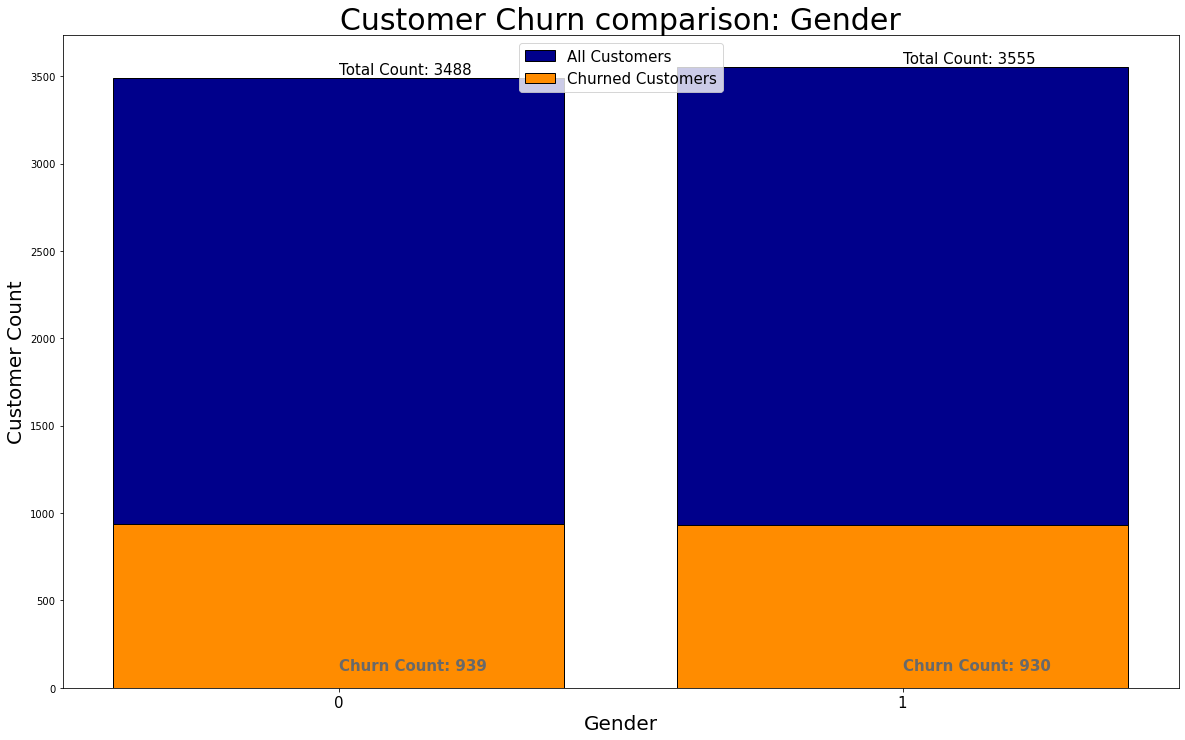

In [34]:
compare_churn('gender')

There does not seem to be any indication here that **gender** plays a role in customer churn. There are a similar number of male and female customers. And both sexes seem to have a similar proportion of their respective groups churning.

### Senior Citizen

,Total Customer Count,Customers Churned Count,% of Customers Churned
SeniorCitizen,,,
0,5901,1393,23.61%
1,1142,476,41.68%


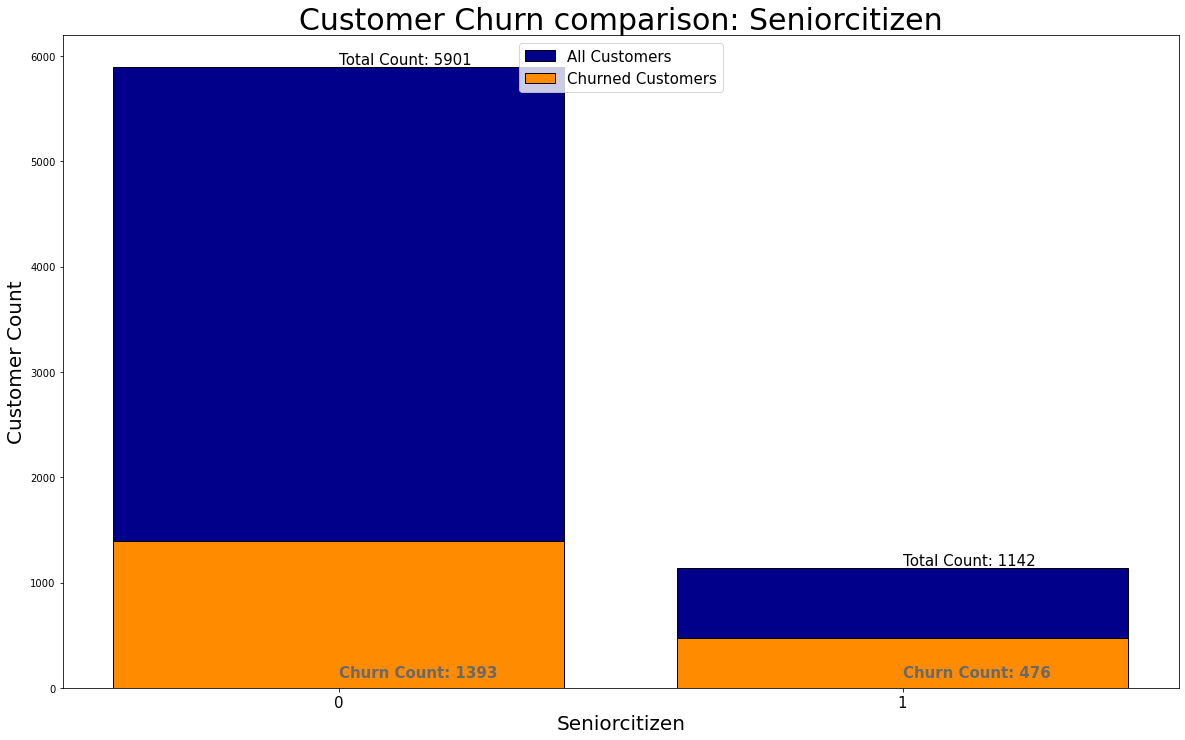

In [35]:
compare_churn('SeniorCitizen')

**Senior citizens** have a higher proportion of customers churning compared to non-senior citizens. Although, one must keep in mind a significantly smaller size in the the total number of senior citizen customers.

### Partner

,Total Customer Count,Customers Churned Count,% of Customers Churned
Partner,,,
0,3641,1200,32.96%
1,3402,669,19.66%


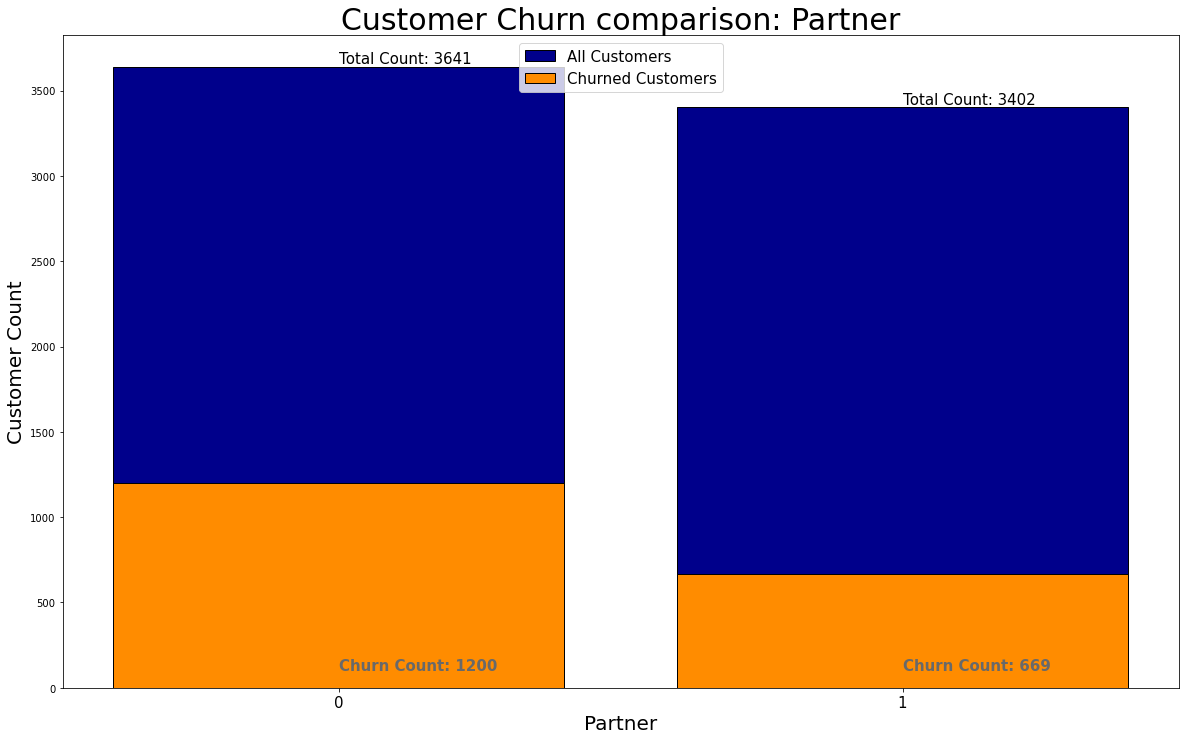

In [36]:
compare_churn('Partner')

Customers without a **Partner** seem to be churning more.

### Dependents

,Total Customer Count,Customers Churned Count,% of Customers Churned
Dependents,,,
0,4933,1543,31.28%
1,2110,326,15.45%


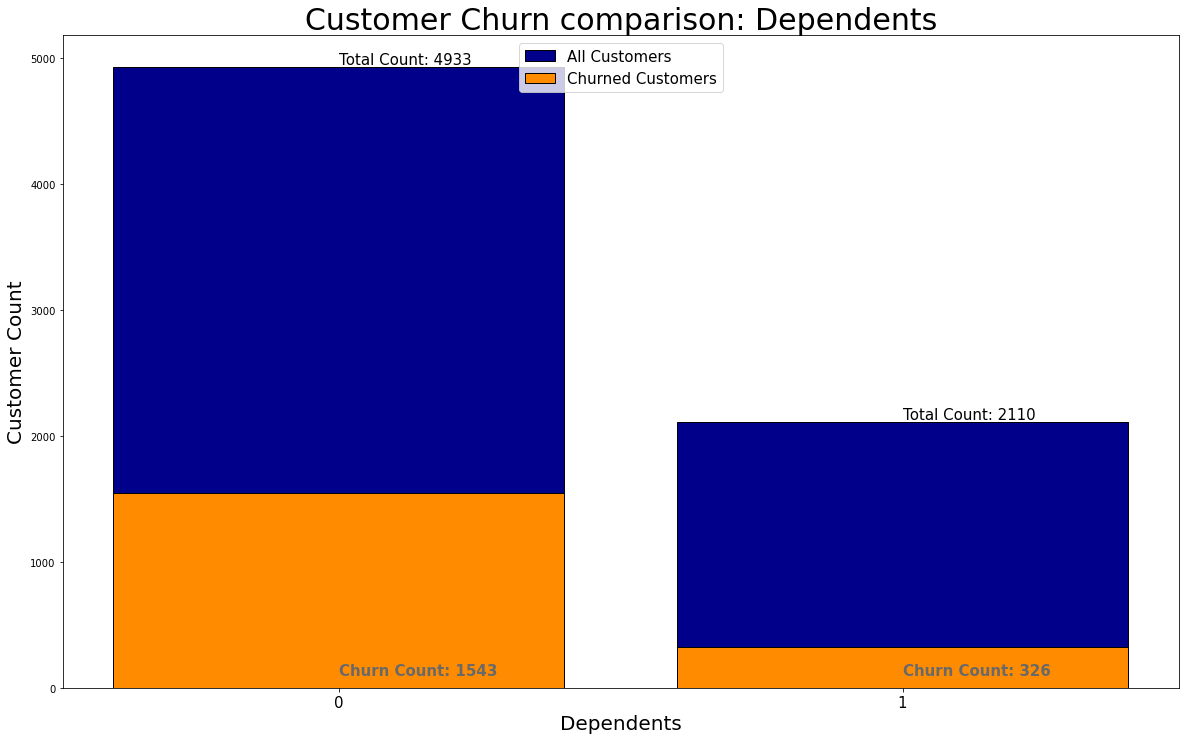

In [37]:
compare_churn('Dependents')

We can see here that customers without **Dependents** are churning more.

### Phone Service

,Total Customer Count,Customers Churned Count,% of Customers Churned
PhoneService,,,
0,682,170,24.93%
1,6361,1699,26.71%


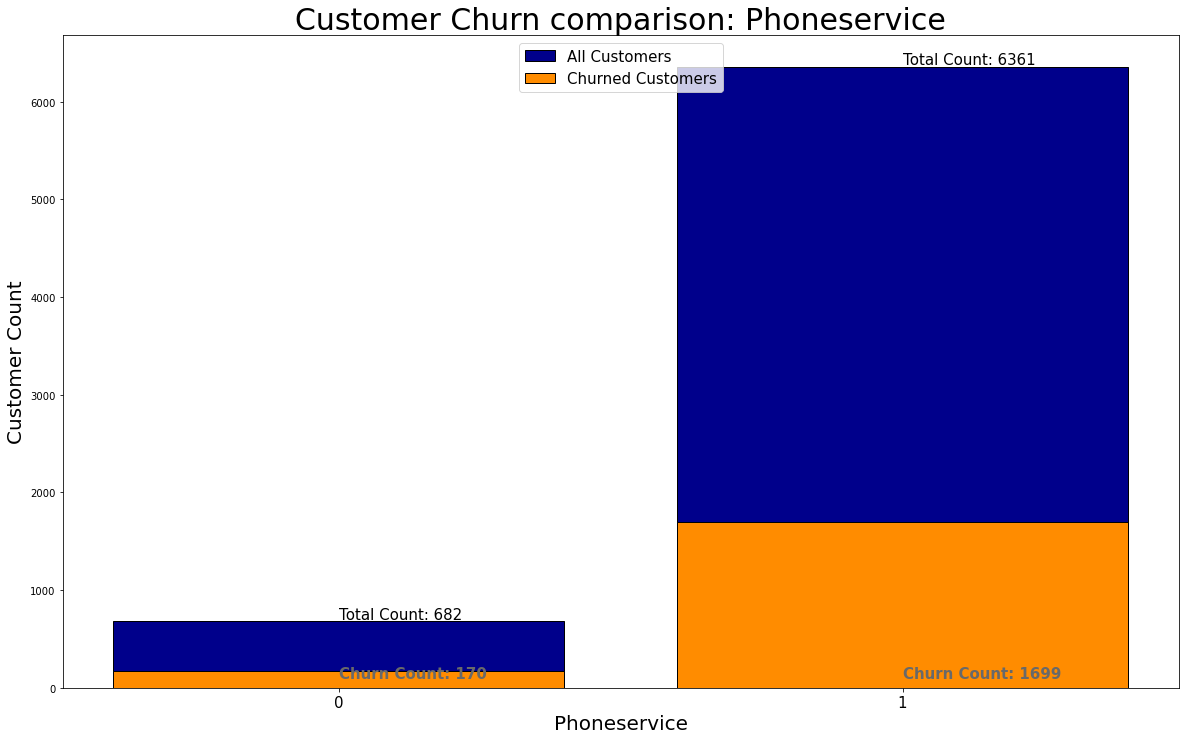

In [38]:
compare_churn('PhoneService')

There are a relatively small number of customers without **Phone Service** so it may not be so easy to compare the two groups. Nonetheless, the % of customers churned for each group is somewhat similar.

### Multiple Lines

,Total Customer Count,Customers Churned Count,% of Customers Churned
MultipleLines,,,
0,4072,1019,25.02%
1,2971,850,28.61%


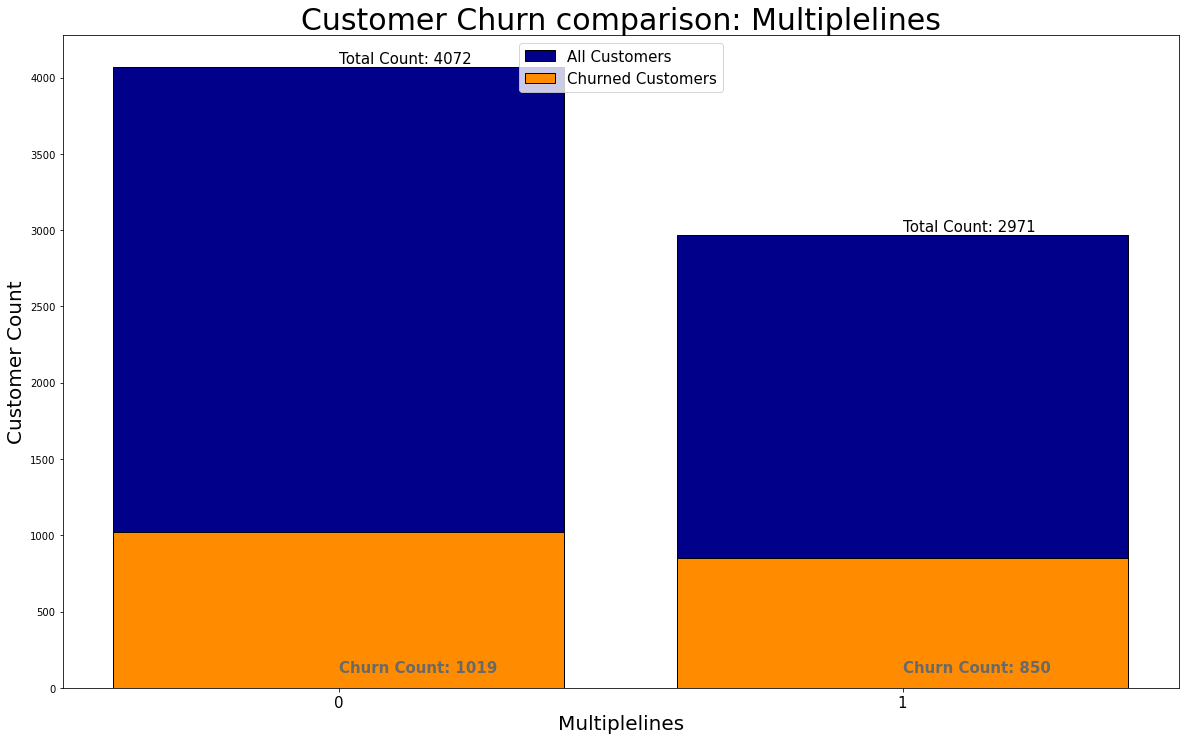

In [39]:
compare_churn('MultipleLines')

For both groups who either have or don't have **Multiple lines**, there isn't much of a difference in % of churned customers. 

### Internet Service

,Total Customer Count,Customers Churned Count,% of Customers Churned
InternetService,,,
0,1526,113,7.4%
1,5517,1756,31.83%


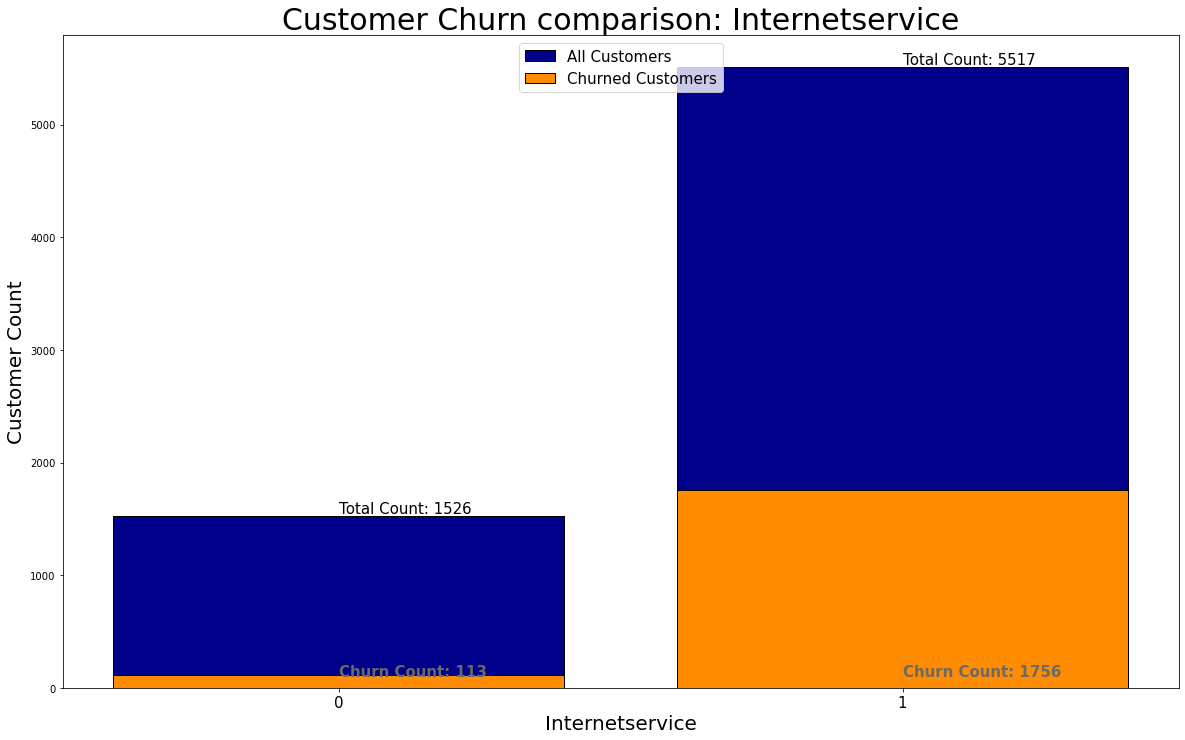

In [40]:
compare_churn('InternetService')

Customers using **Internet service** are churning more when compared with customers without it.

### Online Security

,Total Customer Count,Customers Churned Count,% of Customers Churned
OnlineSecurity,,,
0,5024,1574,31.33%
1,2019,295,14.61%


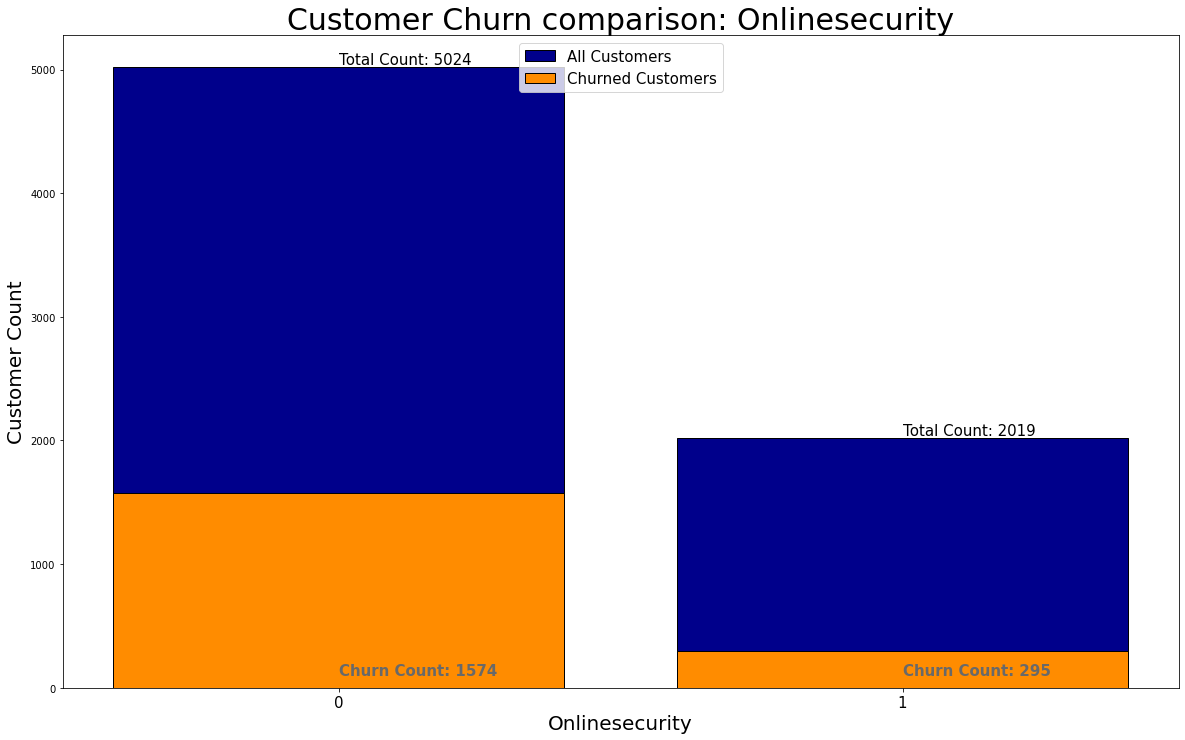

In [41]:
compare_churn('OnlineSecurity')

Customers without **Online Security** are churning more than those who are subscribed to the service.

### Online Backup

,Total Customer Count,Customers Churned Count,% of Customers Churned
OnlineBackup,,,
0,4614,1346,29.17%
1,2429,523,21.53%


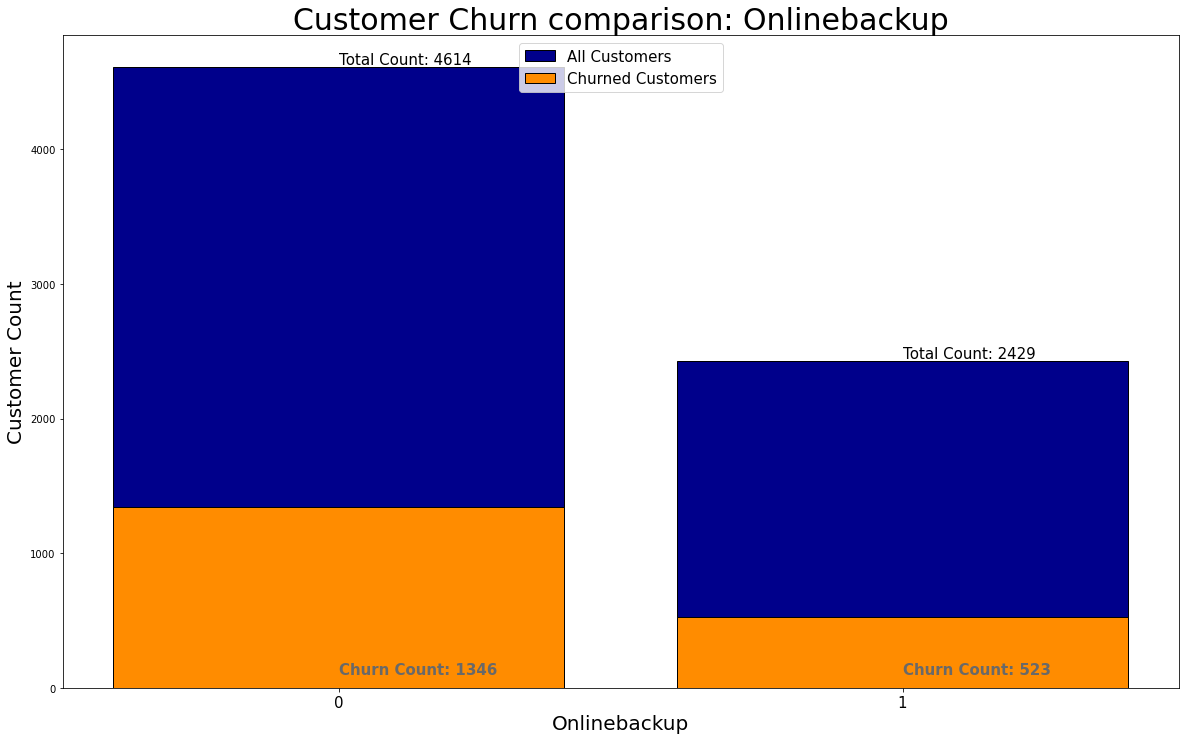

In [42]:
compare_churn('OnlineBackup')

In the case of **Online Backup** as well, customers without the service are churning slightly more.

### Device Protection

,Total Customer Count,Customers Churned Count,% of Customers Churned
DeviceProtection,,,
0,4621,1324,28.65%
1,2422,545,22.5%


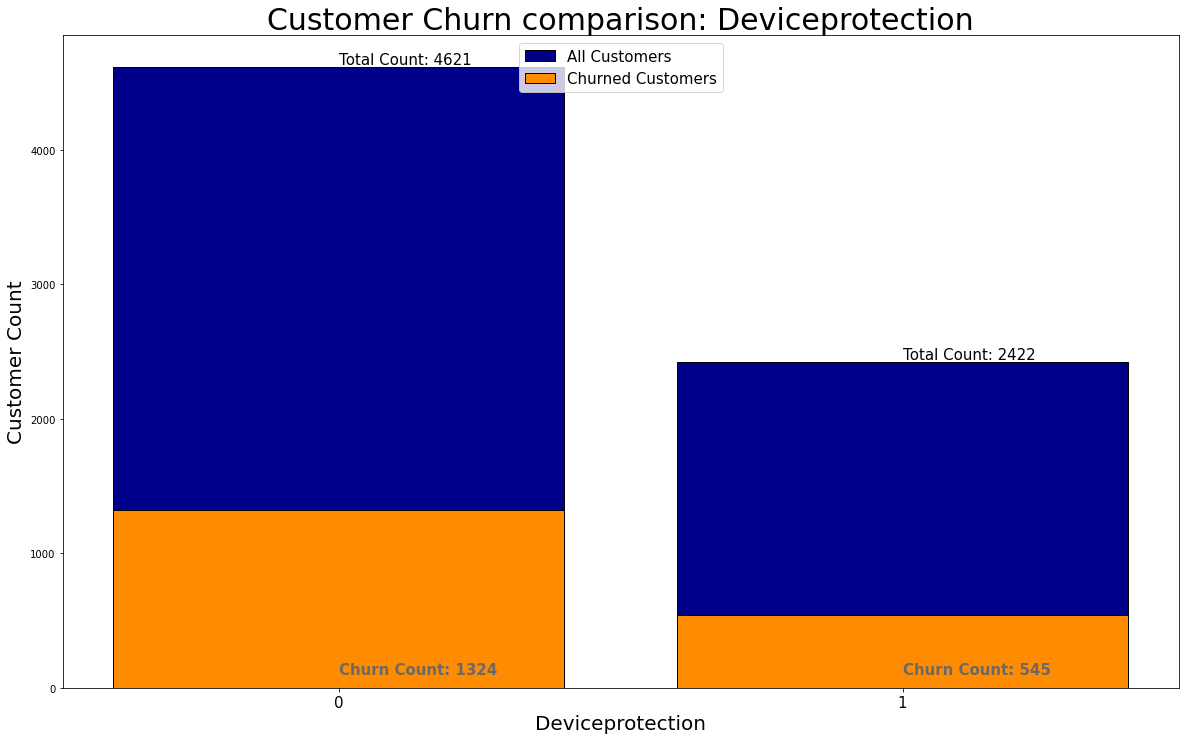

In [43]:
compare_churn('DeviceProtection')

**Device Protection** also seems to have an impact as customers without the service are churning slightly more.

### Tech Support

,Total Customer Count,Customers Churned Count,% of Customers Churned
TechSupport,,,
0,4999,1559,31.19%
1,2044,310,15.17%


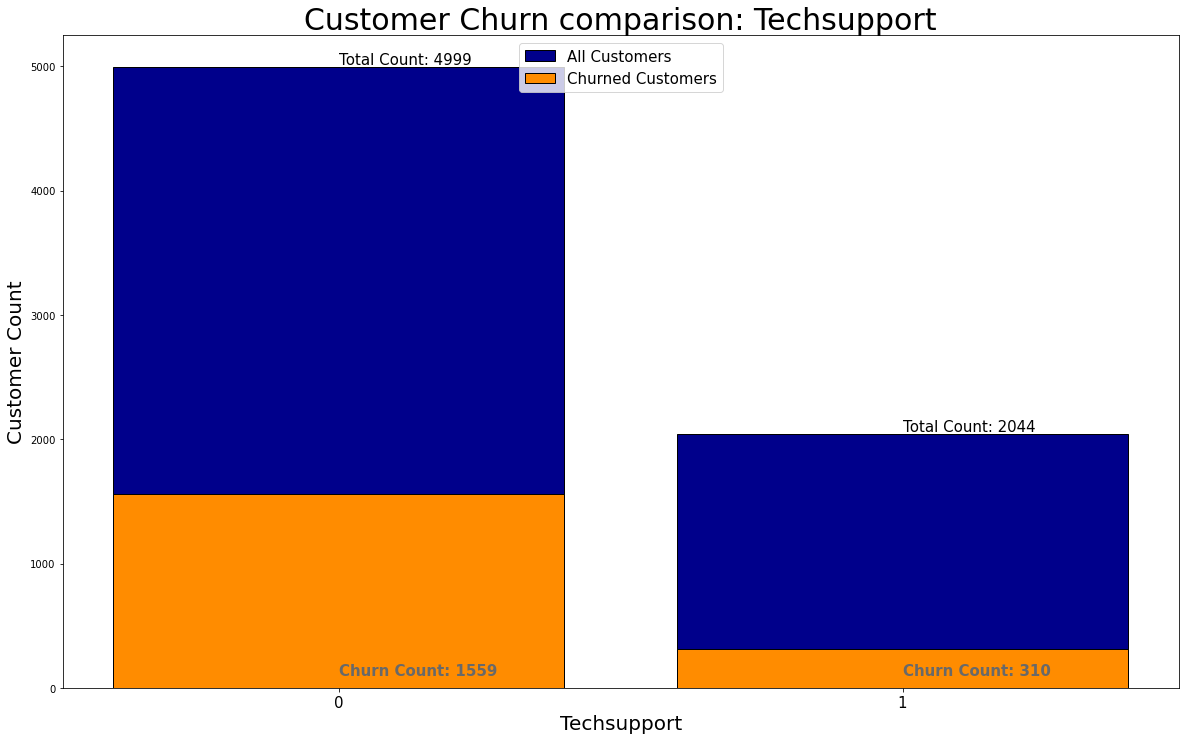

In [44]:
compare_churn('TechSupport')

Customers without **Tech Support** are churning more.

### Streaming TV

,Total Customer Count,Customers Churned Count,% of Customers Churned
StreamingTV,,,
0,4336,1055,24.33%
1,2707,814,30.07%


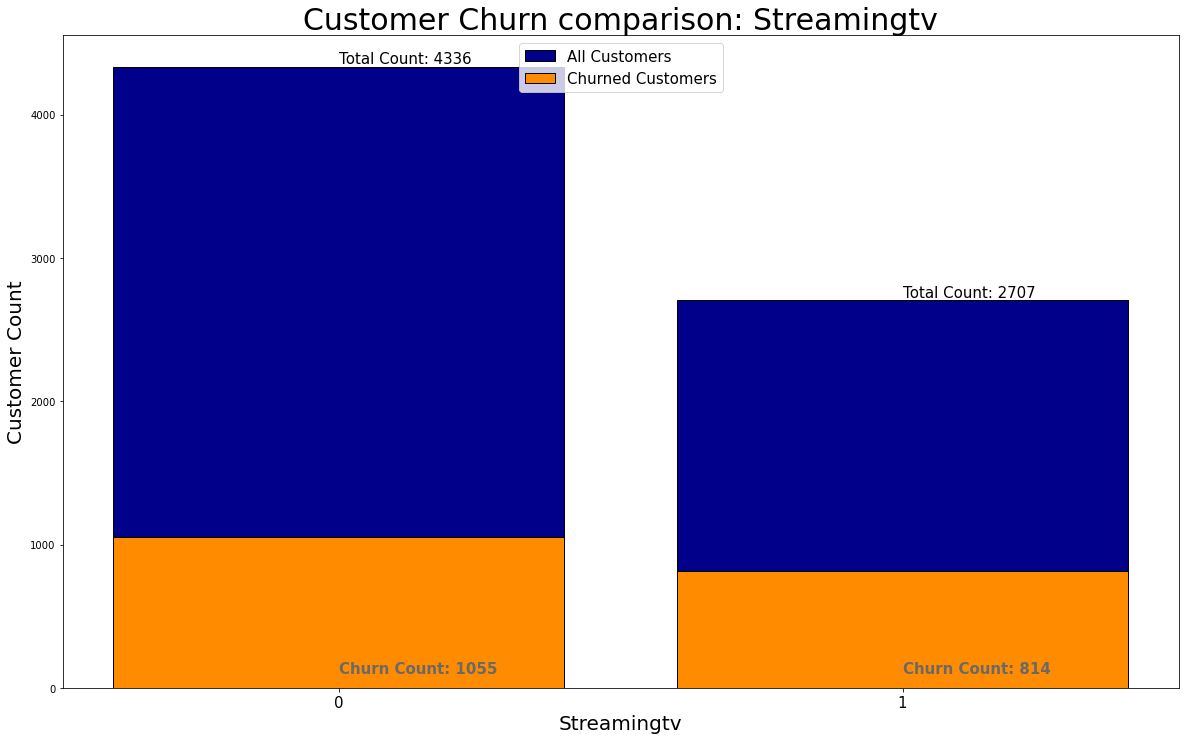

In [45]:
compare_churn('StreamingTV')

There is slightly more churn among customers who have **Streaming TV** subscription.

### Streaming Movies

,Total Customer Count,Customers Churned Count,% of Customers Churned
StreamingMovies,,,
0,4311,1051,24.38%
1,2732,818,29.94%


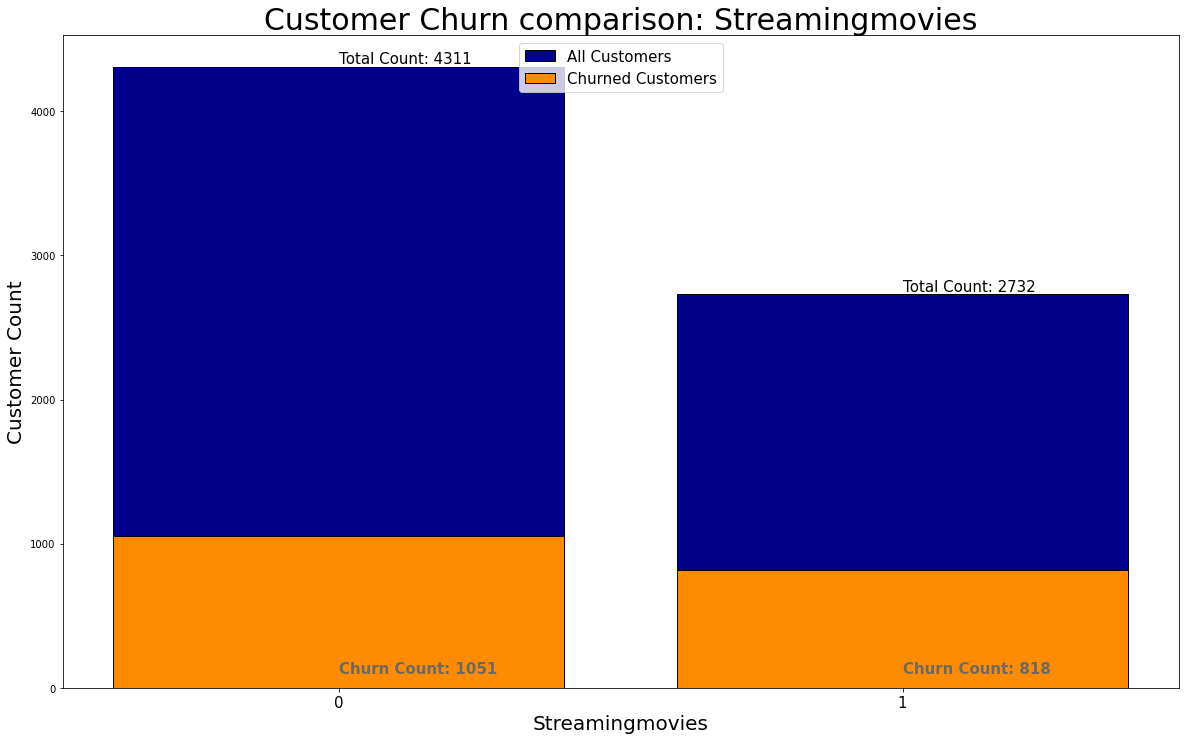

In [46]:
compare_churn('StreamingMovies')

The same goes for **Streaming Movies** as there is slightly more churn among customers who have **Streaming Movies** subscription.

### Loyalty

,Total Customer Count,Customers Churned Count,% of Customers Churned
loyalty,,,
0,3875,1655,42.71%
1,3168,214,6.76%


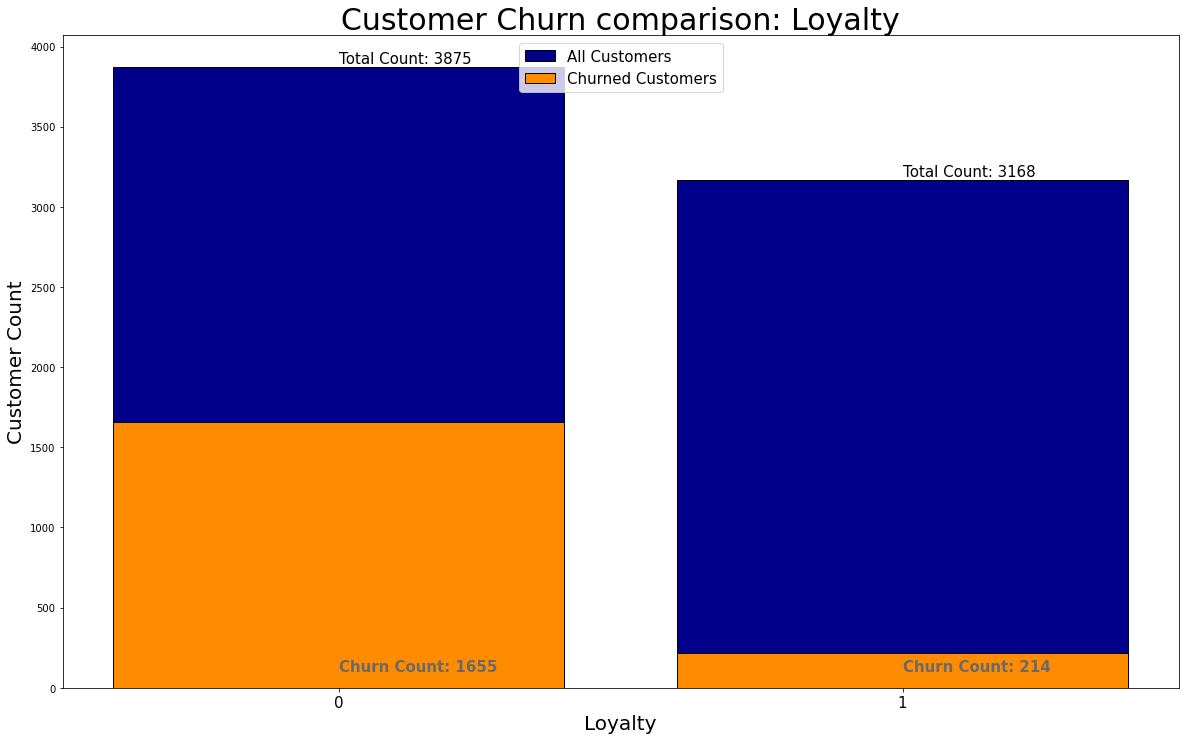

In [47]:
compare_churn('loyalty')

Customers with a month-to-month contract are churning at a significantly higher rate than those on a one-year or two-year contract. This is understandable as it may be more difficult for customers with longer-term contracts to cancel their subscription because they may have paid their fees for the contract duration upfront.

### Paperless Billing

,Total Customer Count,Customers Churned Count,% of Customers Churned
PaperlessBilling,,,
0,2872,469,16.33%
1,4171,1400,33.57%


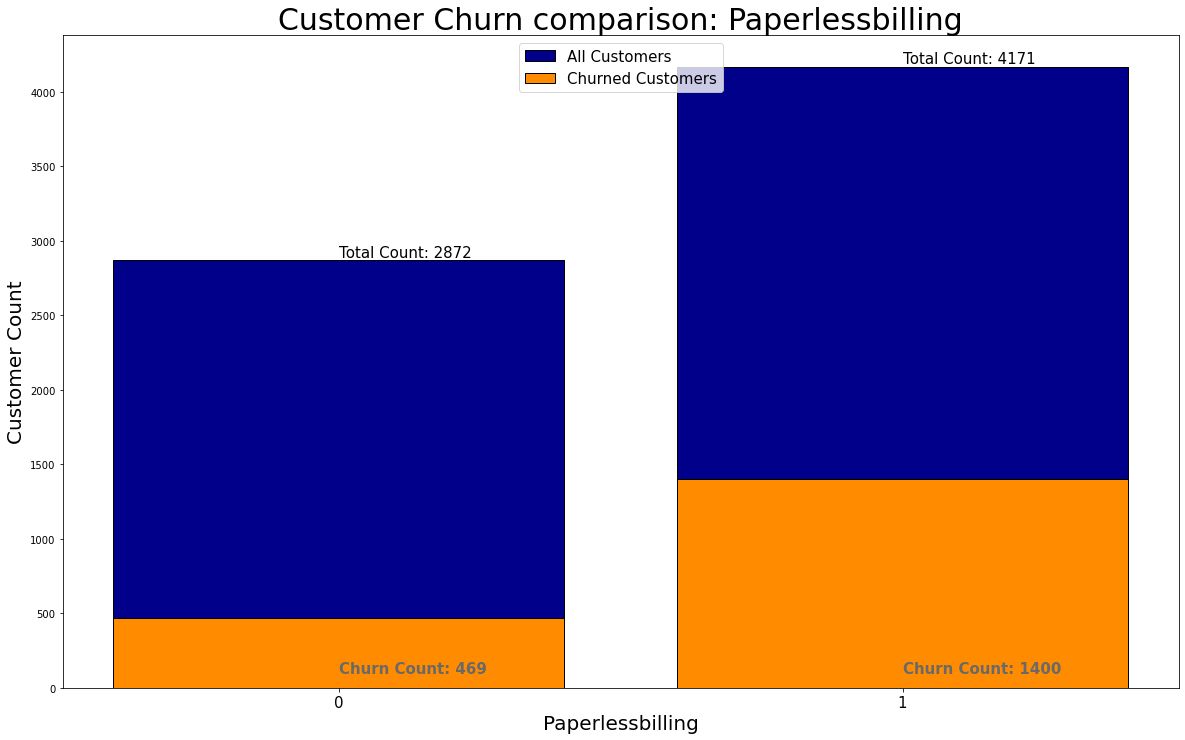

In [48]:
compare_churn('PaperlessBilling')

Customers adopting **Paperless Billing** are churning more.

### Payment Method

,Total Customer Count,Customers Churned Count,% of Customers Churned
PaymentMethod,,,
Bank transfer (automatic),1544,258,16.71%
Credit card (automatic),1522,232,15.24%
Electronic check,2365,1071,45.29%
Mailed check,1612,308,19.11%


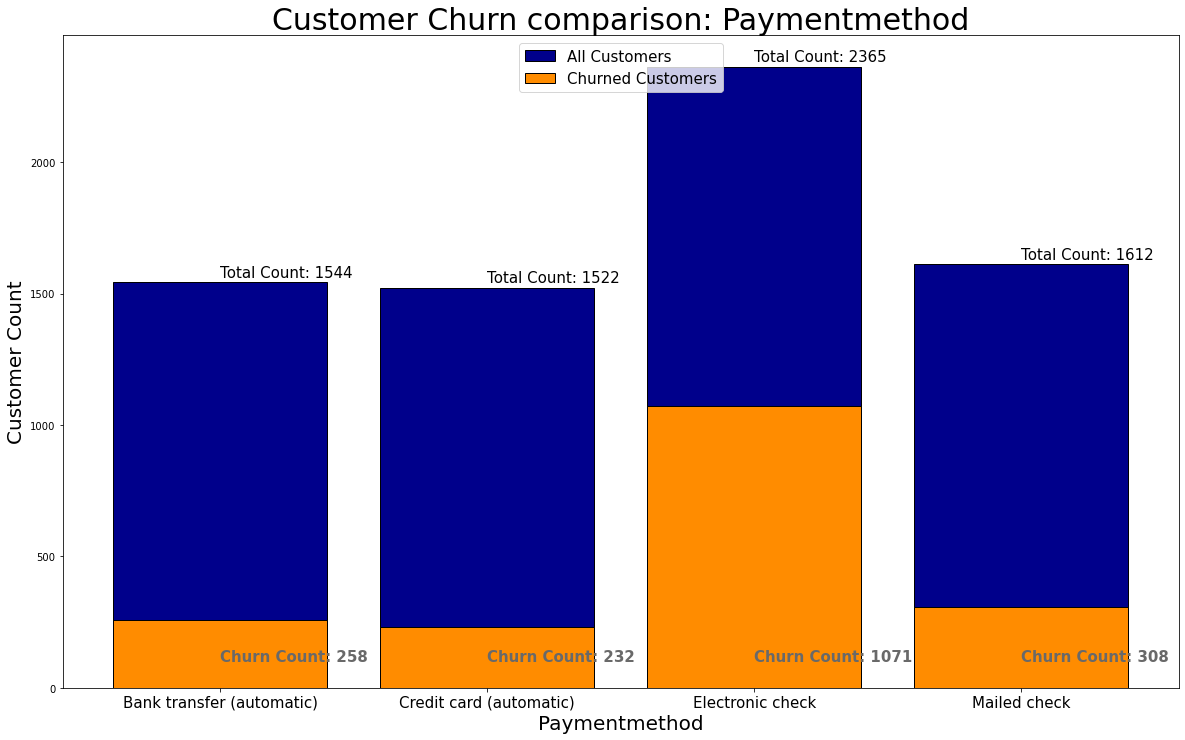

In [49]:
compare_churn('PaymentMethod')

Customers using an electronic check as a **Payment Method** have a much higher rate at which customers are churning.

### Summary

Having looked at the information provided in our features, we can identify what kind of customer is more likely to churn. The following features are the ones that show a a greater proportion of customers churning:

* ***Monthly Charges***
* ***Senior Citizen***
* ***Partner***
* ***Dependents***
* ***Internet Service***
* ***Online Security***
* ***Online Backup***
* ***Device Protection***
* ***Tech Support***
* ***Loyalty***
* ***Paperless Billing***
* ***Payment Method***

## Identifying correlations in Continuous Variable features

Now we let us check for multicollinearity in our features. If the correlation is greater than 0.8, we can conclude that there is a strong correlation. This can help us remove unnecessary features to improve generalization.

### Correlation between Continuous Variable Features

In [50]:
cont_cols = df[['MonthlyCharges', 'TotalCharges', 'tenure']].copy()

In [51]:
cont_cols.corr(method='pearson')

,MonthlyCharges,TotalCharges,tenure
MonthlyCharges,1.000000,0.651182,0.247900
TotalCharges,0.651182,1.000000,0.826164
tenure,0.247900,0.826164,1.000000


As seen from the table above, there is a correlation between **Monthly Charges** and **Total Charges**, and also a strong correlation between **Total Charges** and **Tenure**.

We can later remove **Total Charges** to help reduce multi-colinearity.

## Identifying Mutual Information of our features

We can convert our categorical values to numeric codes to include them in our check for mutual information.

In [52]:
X = df.copy()

In [53]:
X = df.drop('tenure', axis = 1).copy()
y = X.pop('Churn')

#Factorizing the PaymentMethod column
X['PaymentMethod'],_ = X['PaymentMethod'].factorize()

discrete_features = X.dtypes == int

Now that the data has been transformed, let's gather the mutual information scores.

In [54]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='mutual_information оценка', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores.to_frame('Mi_scores')

,Mi_scores
loyalty,0.091887
PaymentMethod,0.044519
TotalCharges,0.044416
MonthlyCharges,0.042718
InternetService,0.031370
PaperlessBilling,0.019194
OnlineSecurity,0.015885
TechSupport,0.014608
Dependents,0.014467
Partner,0.011454


Let's visualize the mi scores to get a better perspective of this information.

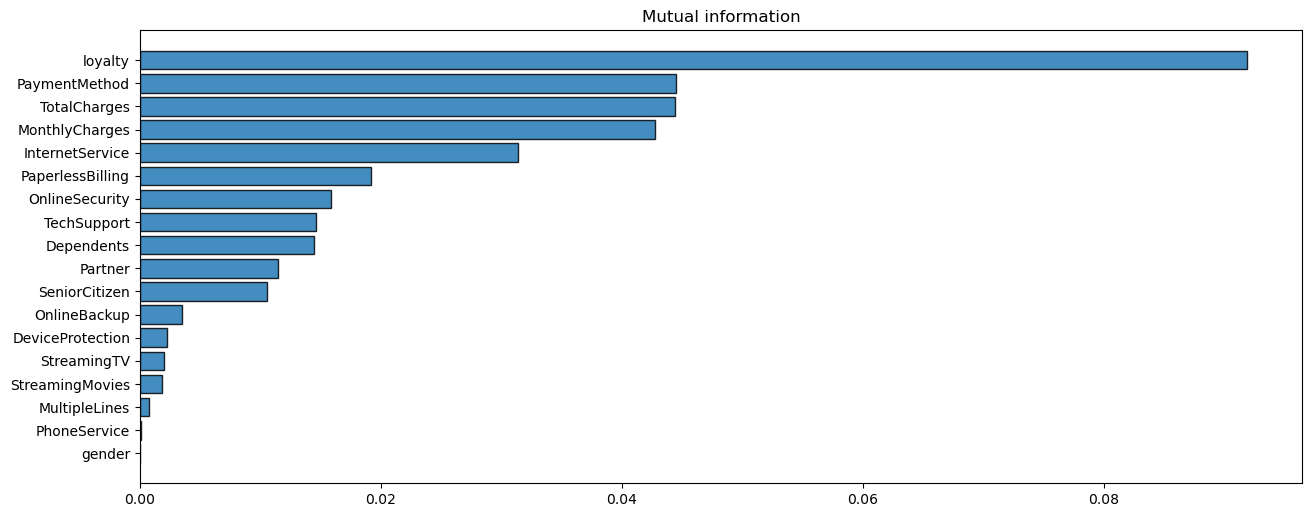

In [55]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, ec='black', alpha=0.84)
    plt.yticks(width, ticks)
    plt.title('Mutual information')


plt.figure(dpi=100, figsize=(15, 6))
plot_mi_scores(mi_scores)

Most of the information for our target- **Churn** is gathered from the following columns:

* **loyalty**  
* **MonthlyCharges** 
* **PaymentMethod**
* **InternetService** 

The **TotalCharges** column was not looked at as it likely has a high multicolinearity with **MonthlyCharges**.

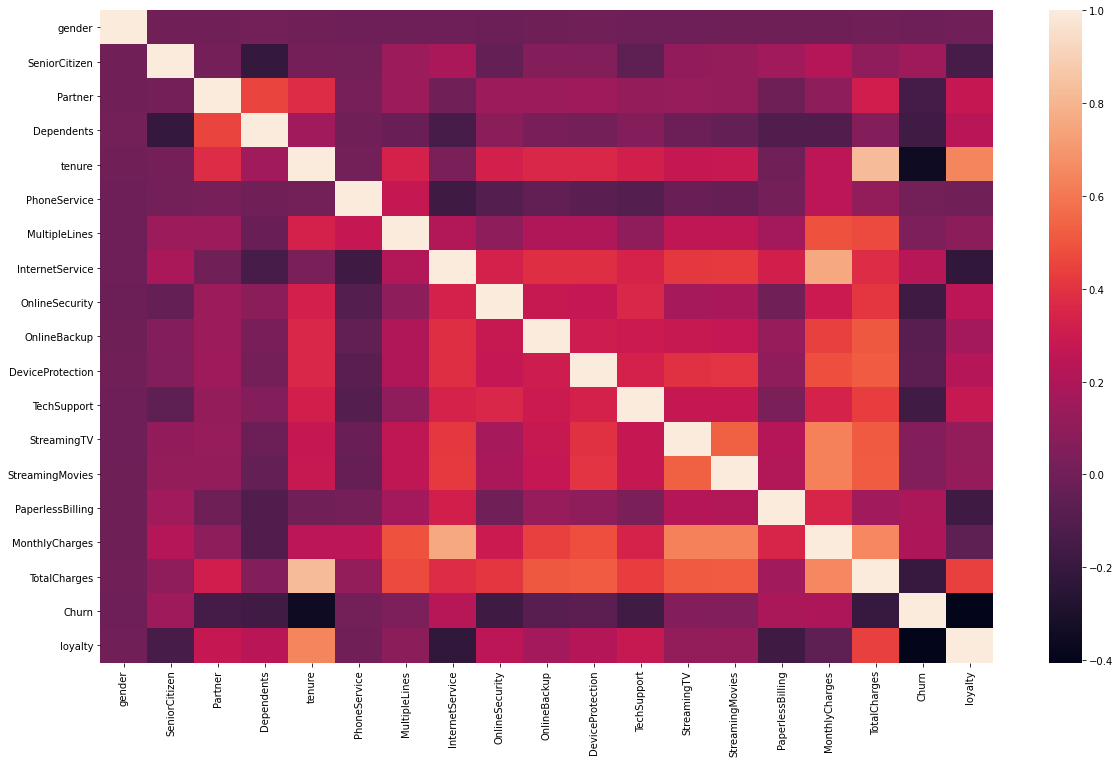

In [56]:
plt.subplots(figsize=(20,12))

sns.heatmap(df.corr());

**TotalCharges** and **tenure** are highly colinear.

## Conclusions

Based on our above exploration we can conclude that this information about customers who churn:


* Customers with month-to-month contracts.
<br>
* Customers within 2 months of subscription (possibly due to end of free trial).
<br>
* Customers paying by Electronic Check.
<br>
* Customers with high Monthly Charge.
<br>
* Customers with Internet Service.
<br>
* Customers adopting PaperlessBilling.
<br>
* Customers that do not have partners and/or dependents.
<br>
* Customers without Tech Support and/or Tech Support.

# Data Pre-Processing & Modeling

### Dropping the ***TotalCharges*** column

As mentioned earlier, we will be dropping the ***TotalCharges*** column to avoide the multicolinearity problem it has with ***tenure*** and ***MonthlyCharges***.

In [57]:
df = df.drop('TotalCharges', axis=1)

### Factorizing the ***PaymentMethod*** column

The ***PaymentMethod*** column will need to converted into numerical groups values.

In [58]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [59]:
# Factorizing the 'Payment Method' column to make the category group names into numerical format
df['PaymentMethod'], _ = df['PaymentMethod'].factorize()

In [60]:
df['PaymentMethod'].value_counts()

0    2365
1    1612
2    1544
3    1522
Name: PaymentMethod, dtype: int64

The 4 groups that were previously stored as string format labels now have numerical values ***(0, 1, 2 & 3)*** instead.

### Defining Functions to Display Model Performance

In [174]:
#Function created to Display Model Performance Metrics
def print_metrics(y_test, preds):
    print("Precision Score: {}".format(precision_score(y_test, preds)))
    print("Recall Score: {}".format(recall_score(y_test, preds)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, preds)))
    print("F1 Score: {}".format(f1_score(y_test, preds)))
    
#Function created to Display ROC Curve
def visualize_roc(y_test, preds):

    fpr, tpr, thresholds = roc_curve(y_test, preds)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')

    plt.show()

    print(f'Recall Score: {recall_score(y_test, preds)}')
    print("Best AUC:", roc_auc_score(y_test, preds))

## Logistic Regression

### Model Assumptions

1. Logistic regression assumes that the response variable only takes on two possible outcomes. i.e. the groups in the predictor column are binary.
<br>

2. Logistic regression assumes that the observations in the dataset are independent of each other. That is, the observations should not come from repeated measurements of the same individual or be related to each other in any way. i.e. The Observations must be Independent.
<br>

3. Logistic regression assumes that there is no severe multicollinearity among the explanatory variables. i.e. There is No Multicollinearity Among Explanatory Variables.
<br>

4. Logistic regression assumes that there are no extreme outliers or influential observations in the dataset. i.e. There are No Extreme Outliers in the data.
<br>

5. Logistic regression assumes that there exists a linear relationship between each explanatory variable and the logit of the response variable.
<br>

6. Logistic regression assumes that the sample size of the dataset if large enough to draw valid conclusions from the fitted logistic regression model.

https://www.statology.org/assumptions-of-logistic-regression/

### Pre-processing Data and Training ***Logistic Regression*** model

In [62]:
#Separating Predictor and Target Variables
X = df.drop('Churn', axis = 1)
y = df['Churn']

#Fixing Class Imbalance in Target Column with SMOTE
smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X, y)

#Splitting Data to Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Train and Test Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Fitting the Logistic Regression model
log_reg = LogisticRegression()

log_reg.fit(X_train_scaled, y_train)

#Getting Predictions from our model
log_reg_preds = log_reg.predict(X_test_scaled)

#Storing Recall score
log_reg_recall = recall_score(y_test,log_reg_preds)

#Checking the Performance of our Logistic Regression Model
print_metrics(y_test, log_reg_preds)

Precision Score: 0.7980480480480481
Recall Score: 0.8246702870442203
Accuracy Score: 0.8086586780054117
F1 Score: 0.8111407859595573


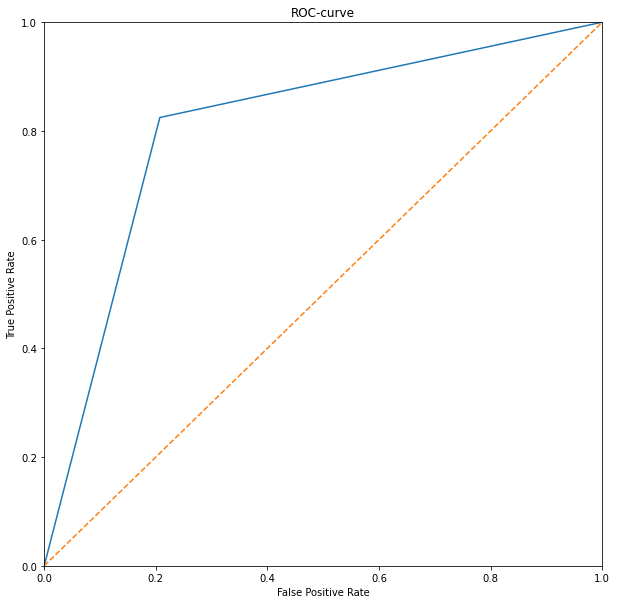

KNN - Recall Score: 0.8246702870442203
KNN - Best AUC: 0.8087141882062395


In [63]:
visualize_roc(y_test,log_reg_preds)

## K-Nearest Neighbors
### Model Assumptions

Must Normalize the Data after train_test_split. This is because the model requires data to be on a standard scale.

**Distance metrics :** Manhattan, Euclidian or Minkowski. Depends on the problem you are solving.

***Things to guide you as you choose the value of K:***

1. As K approaches 1, your prediction becomes less stable.
<br>

2. As your value of K increases, your prediction becomes more stable due to the majority of voters.
<br>

3. When you start receiving an increasing number of errors, you should know you are pushing your K too far. 
<br>

4. Taking a majority vote among labels needs K to be an odd number to have a tiebreaker. 

https://www.mygreatlearning.com/blog/knn-algorithm-introduction/

### Model Evaluation

***Precision***: Out of all the records that we predicted as positive, how many are actually positive?

***Recall***: Out of all the records that are positive, how many did we correctly predict as positive?

***F1 Score***: Balances between precision and recall. Recall: How many Churners did I catch? Precision: How many of the records I identified as churners are actually churners?

### Pre-processing Data and Training ***KNN*** model with default K value

In [64]:
#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Fitting the KNN model
knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train)

#Getting Predictions from our model
knn_preds = knn.predict(X_test_scaled)

#Storing Recall score
knn_recall = recall_score(y_test, knn_preds)

#Checking the Performance of our Logistic Regression Model
print_metrics(y_test, knn_preds)

Precision Score: 0.766016713091922
Recall Score: 0.8533747090768037
Accuracy Score: 0.7970622342481639
F1 Score: 0.8073394495412844


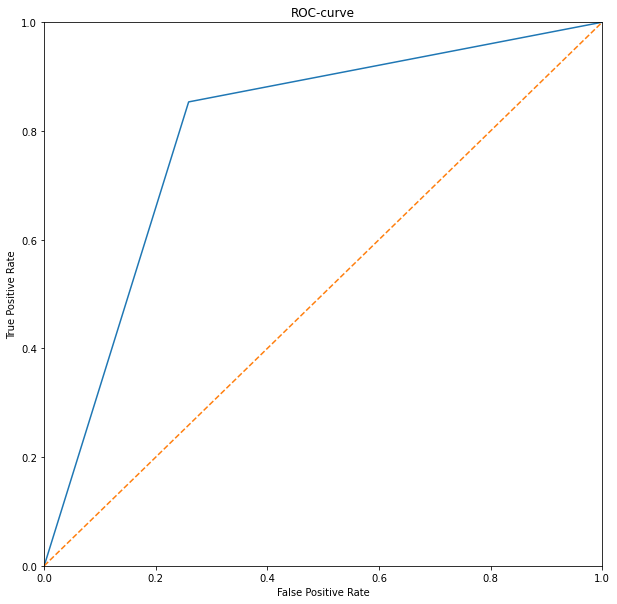

KNN - Recall Score: 0.8533747090768037
KNN - Best AUC: 0.7972574623966452


In [65]:
visualize_roc(y_test,knn_preds)

### Evaluating our Model Performance with the best K value

#Finding the best K-value
def best_knn_prediction(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    best_preds = 0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)
        if recall > best_score:
            best_k = k
            best_score = recall
            best_preds = preds
    print(f'Best k value = {best_k}')
            
    return best_preds, best_k, best_score

best_knn_results = best_knn_prediction(X_train_scaled,
                                      y_train,
                                      X_test_scaled,
                                      y_test,
                                      min_k=1,
                                      max_k=100)

knn_recall = best_knn_results[2]

## Decison Trees

In [66]:
#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Fitting the Decision Tree model
Dt = DecisionTreeClassifier()

Dt.fit(X_train_scaled, y_train)

#Getting Predictions from our model
Dt_preds = Dt.predict(X_test_scaled)

#Storing Recall score
Dt_recall = recall_score(y_test,Dt_preds)

#Checking the Performance of our Decision Tree Model
print_metrics(y_test, Dt_preds)

Precision Score: 0.790188679245283
Recall Score: 0.8122575640031032
Accuracy Score: 0.7989949748743719
F1 Score: 0.8010711553175209


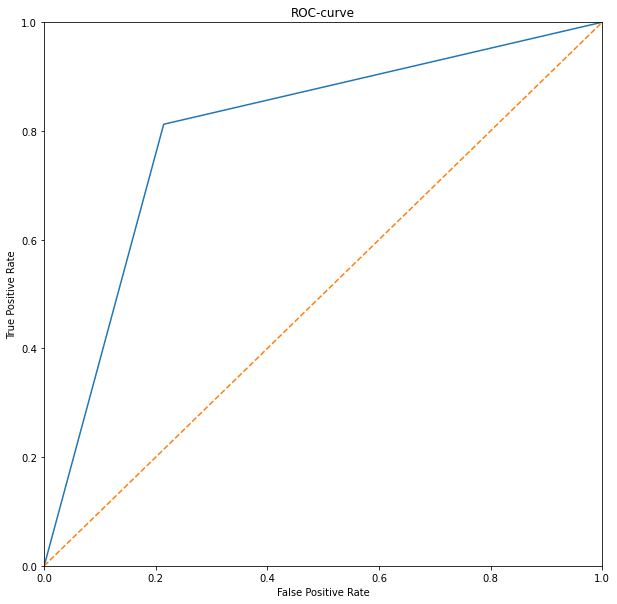

KNN - Recall Score: 0.8122575640031032
KNN - Best AUC: 0.7990409545747412


In [67]:
visualize_roc(y_test, Dt_preds)

## Random Forest

In [68]:
#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Fitting the Random Forest model
rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)

#Getting Predictions from our model
rf_preds = rf.predict(X_test_scaled)

#Storing Recall score
rf_recall = recall_score(y_test,rf_preds)

#Checking the Performance of our Random Forest Model
print_metrics(y_test, rf_preds)

Precision Score: 0.8342205323193916
Recall Score: 0.8510473235065943
Accuracy Score: 0.8415152686509471
F1 Score: 0.8425499231950846


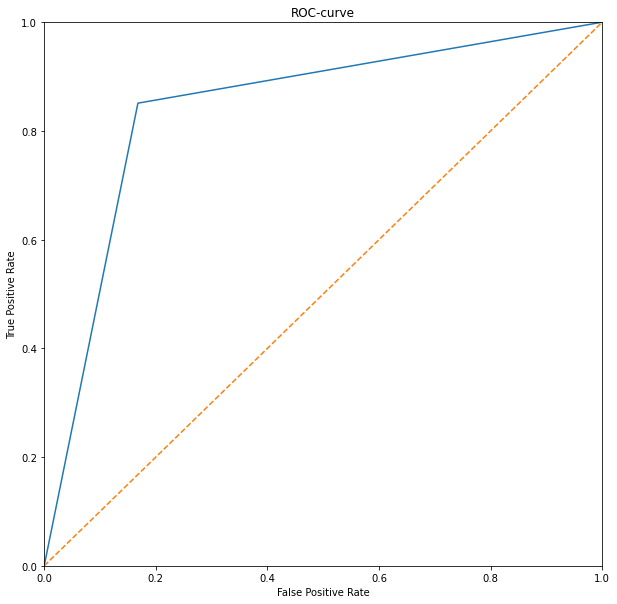

KNN - Recall Score: 0.8510473235065943
KNN - Best AUC: 0.8415483150660862


In [69]:
visualize_roc(y_test, rf_preds)

## XG Boost

In [70]:
#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Instantiating and Fitting the XGBoost Classifier
xgB = XGBClassifier()

xgB.fit(X_train, y_train)

#Deriving Predictions for the Test Data
xgB_preds = xgB.predict(X_test)

#Storing Recall score
xgB_recall = recall_score(y_test,xgB_preds)

#Displaying Performance of the XGBoost Classifier Model with Default Parameters
print_metrics(y_test, xgB_preds)

Precision Score: 0.8244958924570575
Recall Score: 0.8564778898370831
Accuracy Score: 0.8376497873985311
F1 Score: 0.8401826484018265


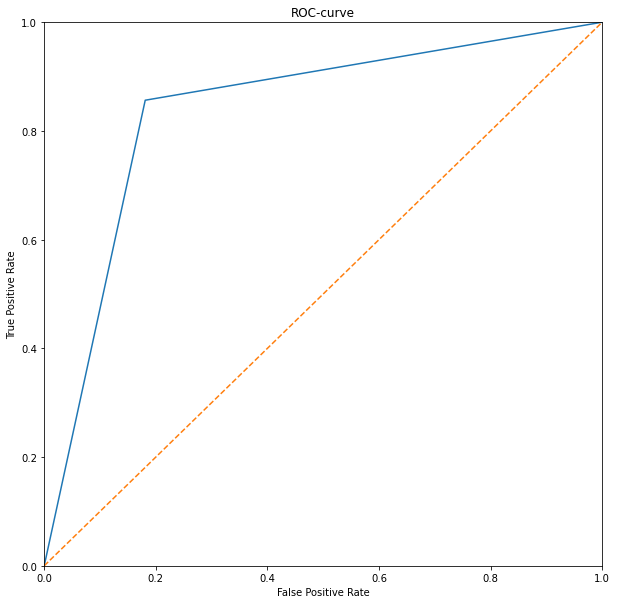

KNN - Recall Score: 0.8564778898370831
KNN - Best AUC: 0.8377150620217771


In [71]:
visualize_roc(y_test, xgB_preds)

parameters: 'scale_pos_weight' for class imbalance issue. No need for Smote.

## Support Vector Machines

In [72]:
#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Fitting the Support Vector Machine Classifier model
SVM = svm.SVC()

SVM.fit(X_train_scaled, y_train)

#Getting Predictions from our model
SVM_preds = SVM.predict(X_test_scaled)

#Storing Recall score
SVM_recall = recall_score(y_test,SVM_preds)

#Checking the Performance of our Support Vector Machine Classifier Model
print_metrics(y_test, SVM_preds)

Precision Score: 0.797645327446652
Recall Score: 0.8409619860356866
Accuracy Score: 0.8144568998840356
F1 Score: 0.8187311178247734


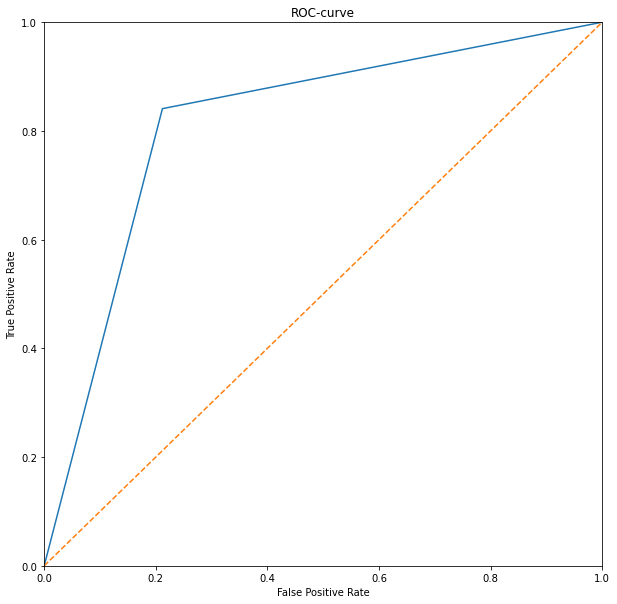

KNN - Recall Score: 0.8409619860356866
KNN - Best AUC: 0.8145487896280128


In [73]:
visualize_roc(y_test, SVM_preds)

# Modeling Results with Default Hyperparameters

Let us look at the recall scores of the classification models we have used.

In [74]:
default_model_scores = [('Logistic Regression',log_reg_recall),
               ('K-Nearest Neighbors',knn_recall),
               ('Decision Tree',Dt_recall),
               ('Random Forest',rf_recall),
               ('XGBoost',xgB_recall),
               ('Support Vector Machines',SVM_recall)]

default_results = pd.DataFrame(default_model_scores,columns = ['Model','Recall Score'])

default_results

,Model,Recall Score
0,Logistic Regression,0.824670
1,K-Nearest Neighbors,0.853375
2,Decision Tree,0.812258
3,Random Forest,0.851047
4,XGBoost,0.856478
5,Support Vector Machines,0.840962


We can now perform hyperparameter tuning on our models to try and see if we can improve them further.

# Modeling Data with better Hyperparameters

## K-Nearest Neighbors

In [75]:
%%capture

#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


#GridSearch
knn_tuning_startTime = datetime.now()

knn_grid = {'n_neighbors' : list(range(1,100,2)),
            'leaf_size': (10,20,30,40,50,60,80,100),
            'weights' : ['uniform','distance'],
            'metric' : ['minkowski','euclidian','manhattan'],
           }

knn_tuning_model = GridSearchCV(knn,
                               param_grid = knn_grid,
                               scoring='recall',
                               cv=3,
                               verbose=5,
                               n_jobs = -1)

#Fitting the tuning model to get best parameters
knn_tuning_model.fit(X_train_scaled,y_train);

#Displaying the best parameters for the Decision Tree Model 
knn_best_params = list((knn_tuning_model.best_params_).values())

In [76]:
print(f'Time Taken to Run: {datetime.now() - knn_tuning_startTime}')

Time Taken to Run: 0:23:10.713612


In [77]:
knn_tuning_model.best_params_

{'leaf_size': 10,
 'metric': 'manhattan',
 'n_neighbors': 97,
 'weights': 'distance'}

In [78]:
#Fitting the KNN model with defined Hyper-Parameters
knn_tuned = KNeighborsClassifier(leaf_size= knn_best_params[0],
                                 metric = knn_best_params[1],
                                 n_neighbors = knn_best_params[2],
                                 weights = knn_best_params[3])

knn_tuned.fit(X_train_scaled, y_train)

#Getting Predictions from our model
knn_tuned_preds = knn_tuned.predict(X_test_scaled)

#Storing Recall score
knn_tuned_recall = recall_score(y_test, knn_tuned_preds)

#Checking the Performance of our Decision Tree Model
print_metrics(y_test, knn_tuned_preds)

Precision Score: 0.7443946188340808
Recall Score: 0.9014740108611327
Accuracy Score: 0.7966756861229223
F1 Score: 0.8154385964912281


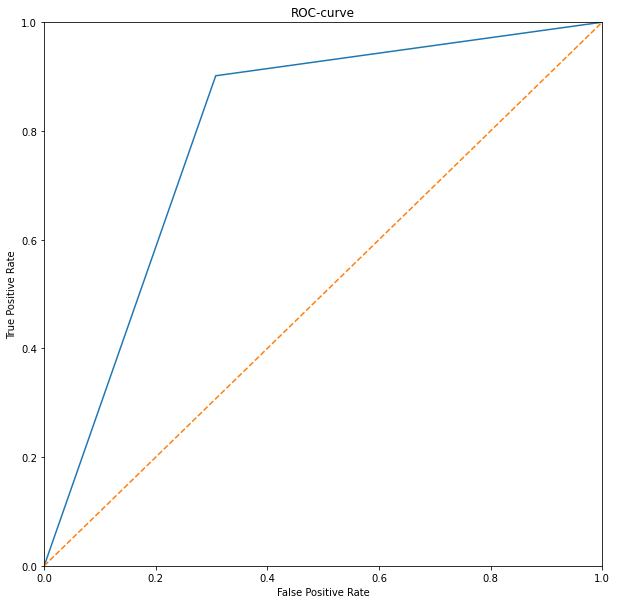

KNN - Recall Score: 0.9014740108611327
KNN - Best AUC: 0.7970390085122304


In [79]:
visualize_roc(y_test, knn_tuned_preds)

## Decision Tree

In [80]:
%%capture

#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#Grid Search
Dt_tuning_startTime = datetime.now()

Dt_parameters={"criterion" : ['gini','entropy'] ,
               "max_depth" : list(range(1,20)),
               "min_samples_split" : list(range(1,20)),
               "min_samples_leaf" : list(range(1,10))}

Dt_tuning_model = GridSearchCV(Dt,
                               param_grid = Dt_parameters,
                               scoring='f1',
                               cv=3,
                               verbose=5)

#Fitting the tuning model to get best parameters
Dt_tuning_model.fit(X_train_scaled,y_train)

#Displaying the best parameters for the Decision Tree Model
Dt_best_params = list((Dt_tuning_model.best_params_).values())

In [81]:
print(f'Time Taken to Run: {datetime.now() - Dt_tuning_startTime}')

Time Taken to Run: 0:04:45.389835


In [82]:
#Fitting the Decision Tree model with defined Hyper-Parameters
Dt_tuned = DecisionTreeClassifier(criterion = Dt_best_params[0],
                                 max_depth = Dt_best_params[1],
                                 min_samples_split= Dt_best_params[2],
                                 min_samples_leaf= Dt_best_params[3])

Dt_tuned.fit(X_train_scaled, y_train)

#Getting Predictions from our model
Dt_tuned_preds = Dt_tuned.predict(X_test_scaled)

#Storing Recall score
Dt_tuned_recall = recall_score(y_test, Dt_tuned_preds)

#Checking the Performance of our Decision Tree Model
print_metrics(y_test, Dt_tuned_preds)

Precision Score: 0.7889374090247453
Recall Score: 0.8409619860356866
Accuracy Score: 0.8086586780054117
F1 Score: 0.8141194141945175


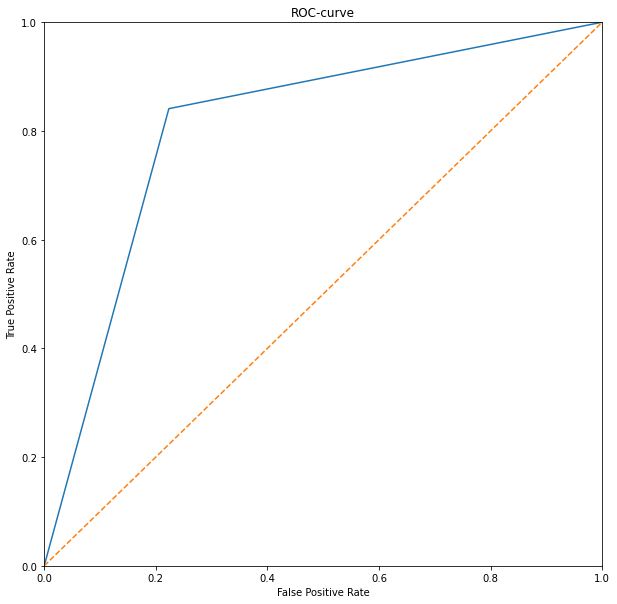

KNN - Recall Score: 0.8409619860356866
KNN - Best AUC: 0.8087706694431128


In [83]:
visualize_roc(y_test, Dt_tuned_preds)

## Random Forest

In [84]:
%%capture

#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


#GridSearch
rf_tuning_startTime = datetime.now()

rf_grid = {'max_depth': [10, 20, 30, 40, 50],
           'max_features': ['auto', 'sqrt'],
           'min_samples_leaf': [1, 2, 4],
           'min_samples_split': [2, 5, 10],
           'n_estimators': [200, 400, 600, 800, 1000, 1200]}

rf_tuning_model = GridSearchCV(rf,
                               param_grid = rf_grid,
                               scoring='recall',
                               cv=3,
                               verbose=5,
                               n_jobs = -1)

#Fitting the tuning model to get best parameters
rf_tuning_model.fit(X_train_scaled,y_train);

#Displaying the best parameters for the Random Forest Model 
rf_best_params = list((rf_tuning_model.best_params_).values())

In [85]:
print(f'Time Taken to Run: {datetime.now() - rf_tuning_startTime}')

Time Taken to Run: 0:53:15.227202


In [86]:
rf_tuning_model.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [87]:
#Fitting the Random Forest model with defined Hyper-Parameters
rf_tuned = RandomForestClassifier(max_depth = rf_best_params[0],
                                  max_features = rf_best_params[1],
                                  min_samples_leaf = rf_best_params[2],
                                  min_samples_split = rf_best_params[3],
                                  n_estimators = rf_best_params[4])

rf_tuned.fit(X_train_scaled, y_train)

#Getting Predictions from our model
rf_tuned_preds = rf_tuned.predict(X_test_scaled)

#Storing Recall score
rf_tuned_recall = recall_score(y_test, rf_tuned_preds)

#Checking the Performance of our Random Forest Model
print_metrics(y_test, rf_tuned_preds)

Precision Score: 0.8075822603719599
Recall Score: 0.8758727695888285
Accuracy Score: 0.8341708542713567
F1 Score: 0.8403423892817269


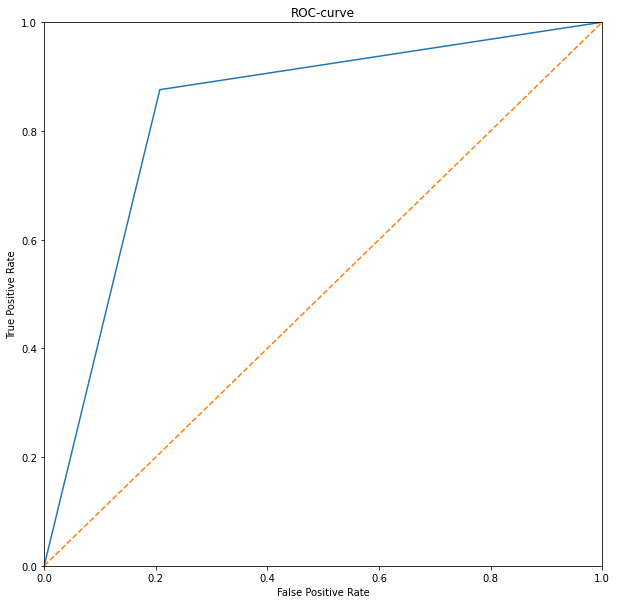

KNN - Recall Score: 0.8758727695888285
KNN - Best AUC: 0.8343154294785436


In [88]:
visualize_roc(y_test, rf_tuned_preds)

## XGBoost

**hyperparameters** : shrinkage parameter, depth of the tree, number of trees

https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30

In [102]:
%%capture
#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

#GridSearch
xgB_tuning_startTime = datetime.now()

xgB_grid = {'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }

xgB_tuning_model = GridSearchCV(xgB,
                               param_grid = xgB_grid,
                               scoring='recall',
                               cv=3,
                               verbose=5,
                               n_jobs = -1)


#Fitting the tuning model to get best parameters
xgB_tuning_model.fit(X_train_scaled,y_train);

#Displaying the best parameters for the XGBoost Model 
xgB_best_params = list((xgB_tuning_model.best_params_).values())

In [103]:
print(f'Time Taken to Run: {datetime.now() - xgB_tuning_startTime}')

Time Taken to Run: 0:06:03.885296


In [104]:
xgB_tuning_model.best_params_

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.8}

In [105]:
#Fitting the XGBoost model with defined Hyper-Parameters
xgB_tuned = XGBClassifier(colsample_bytree = xgB_best_params[0],
                          gamma = xgB_best_params[1],
                          max_depth = xgB_best_params[2],
                          min_child_weight = xgB_best_params[3],
                          subsample = xgB_best_params[4])

xgB_tuned.fit(X_train_scaled, y_train)

#Getting Predictions from our model
xgB_tuned_preds = xgB_tuned.predict(X_test_scaled)

#Storing Recall score
xgB_tuned_recall = recall_score(y_test, xgB_tuned_preds)

#Checking the Performance of our XGBoost Model
print_metrics(y_test, xgB_tuned_preds)

Precision Score: 0.8148967551622419
Recall Score: 0.8572536850271528
Accuracy Score: 0.8318515655199072
F1 Score: 0.8355387523629489


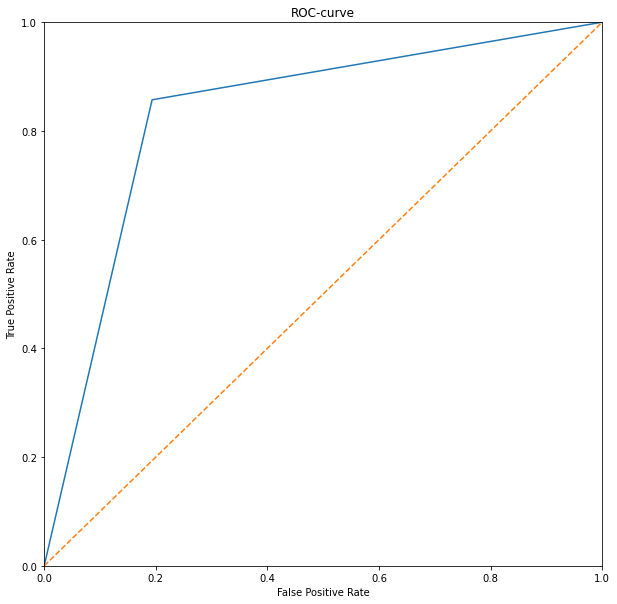

KNN - Recall Score: 0.8572536850271528
KNN - Best AUC: 0.8319396314195857


In [106]:
visualize_roc(y_test, xgB_tuned_preds)

## Support Vector Machines

In [160]:
%%capture

#Splitting the Data into X and y
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Using Smote to fix Class Imbalance Issue
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

#Splitting the Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 42)

#Scaling the Data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


#GridSearch
SVM_tuning_startTime = datetime.now()

SVM_grid = {'kernel': ['rbf'],
            'C': [0.1, 1, 10, 100],
            'gamma': [10 ,1, 0.1, 0.01, 0.001]
           }

SVM_tuning_model = GridSearchCV(SVM,
                               param_grid = SVM_grid,
                               scoring='recall',
                               cv=3,
                               verbose=5,
                               n_jobs = -1)

#Fitting the tuning model to get best parameters
SVM_tuning_model.fit(X_train_scaled,y_train);

#Displaying the best parameters for the Decision Tree Model 
SVM_best_params = list((SVM_tuning_model.best_params_).values())

In [161]:
print(f'Time Taken to Run: {datetime.now() - SVM_tuning_startTime}')

Time Taken to Run: 0:00:58.599430


In [162]:
SVM_tuning_model.best_params_

{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

In [163]:
SVM_best_params

[0.1, 0.001, 'rbf']

In [164]:
#Fitting the Support Vector Machines model with defined Hyper-Parameters
SVM_tuned = svm.SVC(C = SVM_best_params[0],
                    gamma = SVM_best_params[1],
                    kernel = SVM_best_params[2])

SVM_tuned.fit(X_train_scaled, y_train)

#Getting Predictions from our model
SVM_tuned_preds = SVM_tuned.predict(X_test_scaled)

#Storing Recall score
SVM_tuned_recall = recall_score(y_test,SVM_tuned_preds)

#Checking the Performance of our Support Vector Machines Model
print_metrics(y_test, SVM_tuned_preds)

Precision Score: 0.7369085173501577
Recall Score: 0.9061287820015516
Accuracy Score: 0.7920371086200232
F1 Score: 0.8128044537230341


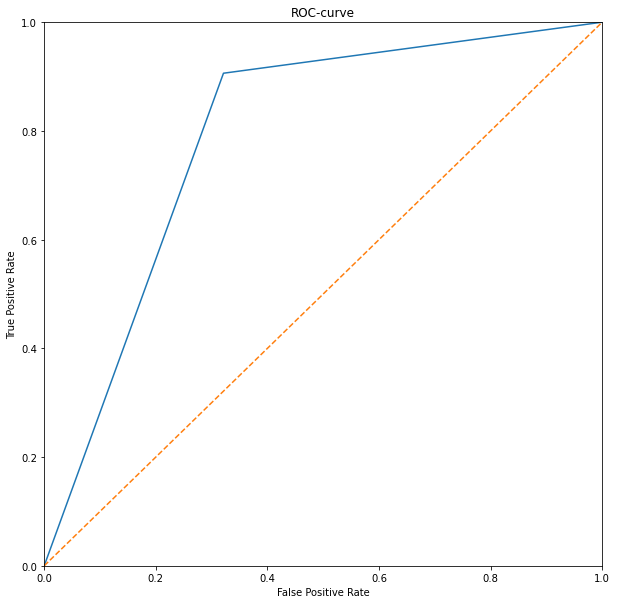

Recall Score: 0.9061287820015516
Best AUC: 0.7924326498605601


In [175]:
visualize_roc(y_test, SVM_tuned_preds)

In [176]:
tuned_model_scores = [('Logistic Regression Tuned',log_reg_recall),
               ('K-Nearest Neighbors Tuned',knn_tuned_recall),
               ('Decision Tree Tuned',Dt_tuned_recall),
               ('Random Forest Tuned',rf_tuned_recall),
               ('XGBoost Tuned',xgB_tuned_recall),
               ('Support Vector Machines Tuned',SVM_tuned_recall)]

tuned_results = pd.DataFrame(tuned_model_scores,columns = ['Model','Recall Score'])

tuned_results

,Model,Recall Score
0,Logistic Regression Tuned,0.824670
1,K-Nearest Neighbors Tuned,0.901474
2,Decision Tree Tuned,0.840962
3,Random Forest Tuned,0.875873
4,XGBoost Tuned,0.857254
5,Support Vector Machines Tuned,0.906129


In [173]:
default_results

,Model,Recall Score
0,Logistic Regression,0.824670
1,K-Nearest Neighbors,0.853375
2,Decision Tree,0.812258
3,Random Forest,0.851047
4,XGBoost,0.856478
5,Support Vector Machines,0.840962
